# ACCESS-S2-RA-explore

**Date:** <br>
14 December 2021 <br>
**Background:** <br>
Issue -  <br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [48]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=24)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

<Client: 'tcp://10.0.128.147:38195' processes=0 threads=0, memory=0 B>

***

# load main S2 collections from zarr

In [10]:
%%time
ds_S2_u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.regrid_1deg.zarr',consolidated=True)
ds_S2_v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.regrid_1deg.zarr',consolidated=True)
ds_S2_KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.regrid_1deg.zarr',consolidated=True)
ds_S2_Tocean = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.Tregrid_1deg.zarr',consolidated=True)

CPU times: user 62.9 ms, sys: 12.3 ms, total: 75.2 ms
Wall time: 96.5 ms


# Grid information for ACCESS S2?

In [11]:
%%time
ds_S2_Ugrid = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_1990.nc')
ds_S2_Vgrid = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_1990.nc')
ds_S2_Tgrid = xr.open_dataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_1990.nc')

CPU times: user 66 ms, sys: 13.4 ms, total: 79.4 ms
Wall time: 101 ms


## S2 depth weights

In [12]:
S2_depth_weights = ds_S2_Tgrid.deptht_bounds.diff(dim='ndepth_bounds').squeeze().rename({'deptht':'depth'})

***

In [13]:
ds_S2_Tgrid.temp.max().values

array(33.79156876)

In [14]:
ds_S2_Tgrid.temp.isel(deptht=0,time_counter=0)

<xarray.DataArray 'temp' (y: 1021, x: 1442)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    deptht        float32 0.5058
    nav_lat       (y, x) float32 ...
    nav_lon       (y, x) float32 ...
    time_counter  datetime64[ns] 1990-01-16T12:00:00
Dimensions without coordinates: y, x
Attributes:
    units:               degC
    standard_name:       sea_water_potential_temperature
    long_name:           Temperature
    online_operation:    ave(X)
    interval_operation:  1350.0
    interval_write:      86400.0
    cell_measures:       area: areat
    cell_methods:        time_counter: mean

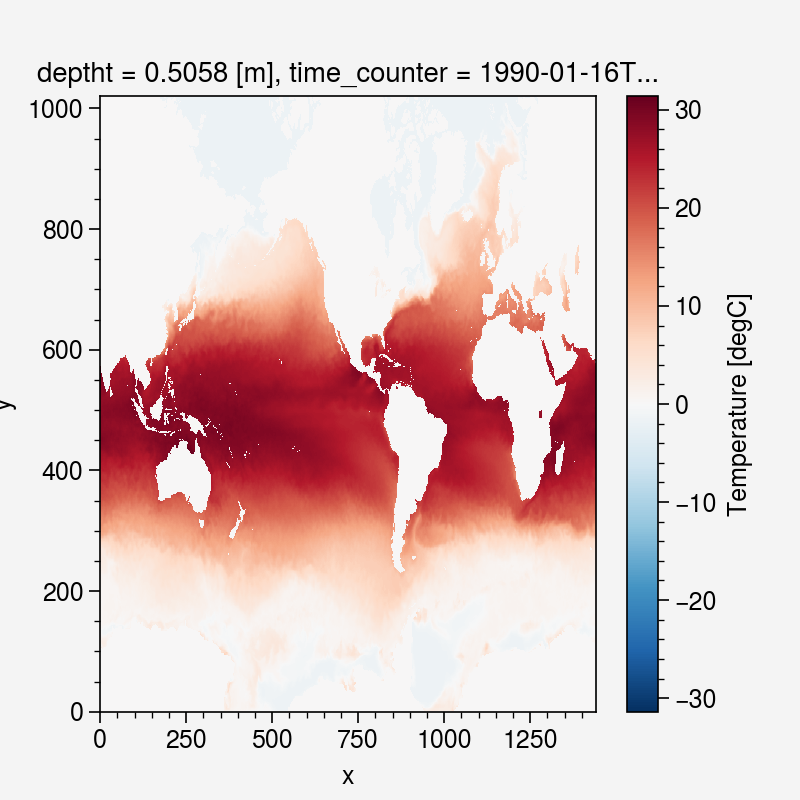

In [15]:
ds_S2_Tgrid.temp.isel(deptht=0,time_counter=0).plot()

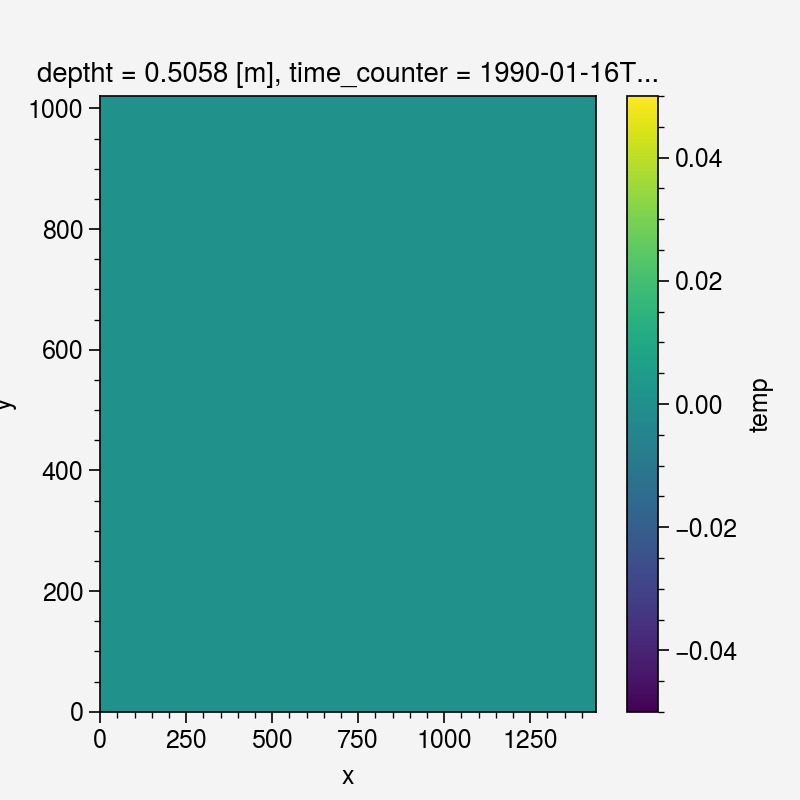

In [16]:
ds_S2_Tgrid.temp.isel(deptht=0,time_counter=0).isnull().plot()

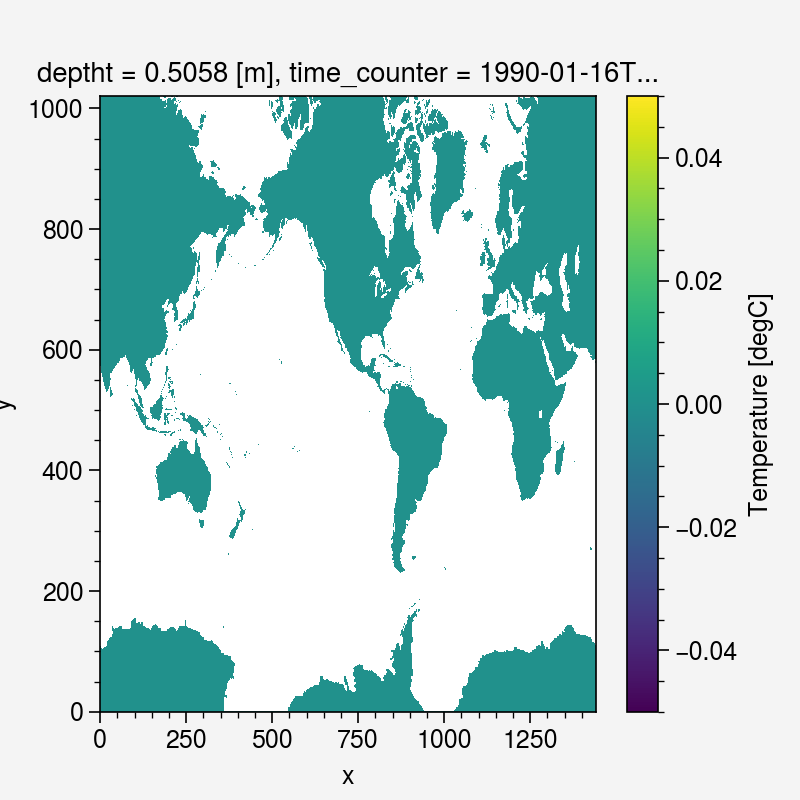

In [17]:
ds_S2_Tgrid.temp.isel(deptht=0,time_counter=0).where(ds_S2_Tgrid.temp.isel(deptht=0,time_counter=0)==0).plot()

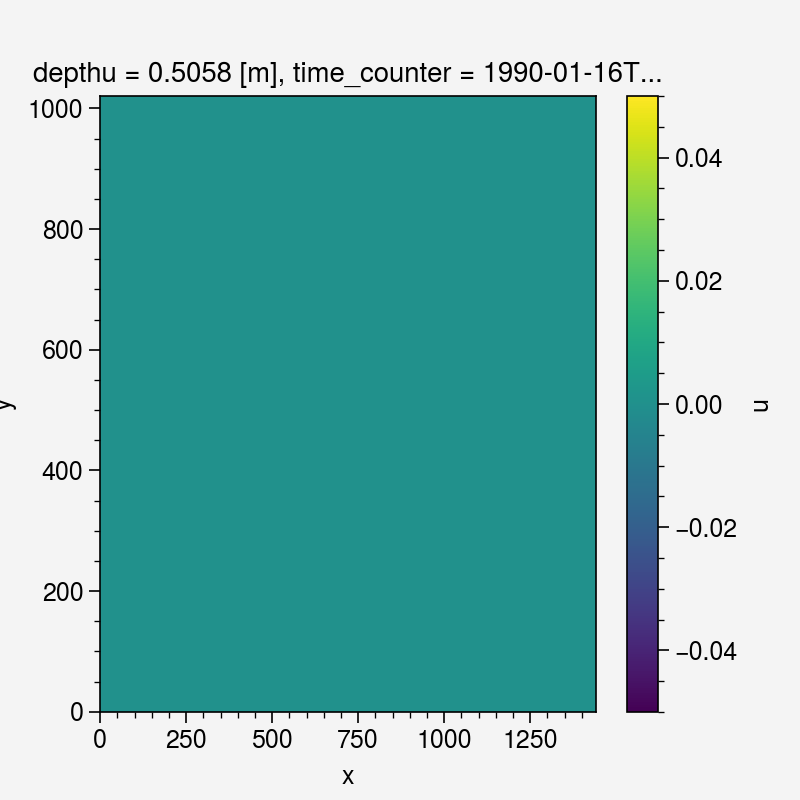

In [18]:
ds_S2_Ugrid.u.isel(depthu=0,time_counter=0).isnull().plot()

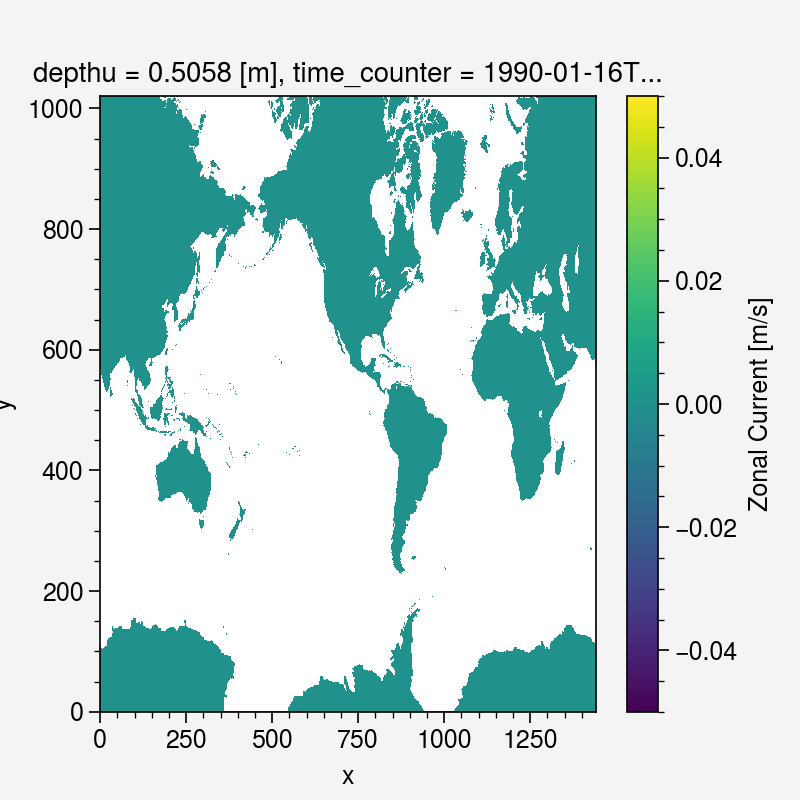

In [19]:
ds_S2_Ugrid.u.isel(depthu=0,time_counter=0).where(ds_S2_Ugrid.u.isel(depthu=0,time_counter=0)==0).plot()

# CAFE60 comparison

In [21]:
ds_CAFE60 = xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')

In [22]:
ds_CAFE60

<xarray.Dataset>
Dimensions:                 (time: 720, ensemble: 96, st_ocean: 50, yt_ocean: 300, xt_ocean: 360, sw_ocean: 50, xu_ocean: 360, yu_ocean: 300)
Coordinates:
  * ensemble                (ensemble) int32 1 2 3 4 5 6 7 ... 91 92 93 94 95 96
  * st_ocean                (st_ocean) float64 5.0 15.0 ... 5.499e+03 5.831e+03
  * sw_ocean                (sw_ocean) float64 10.0 20.0 ... 5.665e+03 6e+03
  * time                    (time) object 1960-01-16 12:00:00 ... 2019-12-16 ...
  * xt_ocean                (xt_ocean) float64 -279.5 -278.5 ... 78.5 79.5
  * xu_ocean                (xu_ocean) float64 -279.0 -278.0 ... 79.0 80.0
  * yt_ocean                (yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77
  * yu_ocean                (yu_ocean) float64 -77.75 -77.51 ... 89.55 90.0
Data variables: (12/22)
    age_global              (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    cfc_11                  (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    cfc_12                  (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    eta_t                   (time, ensemble, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 300, 360), meta=np.ndarray>
    neutral_diffusion_salt  (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    neutral_diffusion_temp  (time, ensemble, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    ...                      ...
    tx_trans_gm             (time, ensemble, st_ocean, yt_ocean, xu_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    ty_trans                (time, ensemble, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    ty_trans_gm             (time, ensemble, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    u                       (time, ensemble, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    v                       (time, ensemble, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
    wt                      (time, ensemble, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 96, 3, 300, 360), meta=np.ndarray>
Attributes: (12/24)
    calendar:                 julian
    cm-enkf_source:          commit 0141830a243704acbf6d8c8c843b161a39ec39fa
    contact_name:            Decadal Activity 1 - Data Assimilation
    control_name:            c5
    creation_date:           Thu Apr 23 08:05:39 2020
    data_assimilation_name:  d60
    ...                      ...
    model_source:            commit 2abb29f4384e68777721fa657850587f28efd85a
    nominal_resoltuion:      Atmosphere delta lat = 2.02degrees ; Atmosphere ...
    perturbation_name:       not applicable
    references:              OKane, T.J., Sandery, P.A., Monselesan, D.P., Sa...
    run_variant_name:        data assimilation
    title:                   AccessOcean-AM2

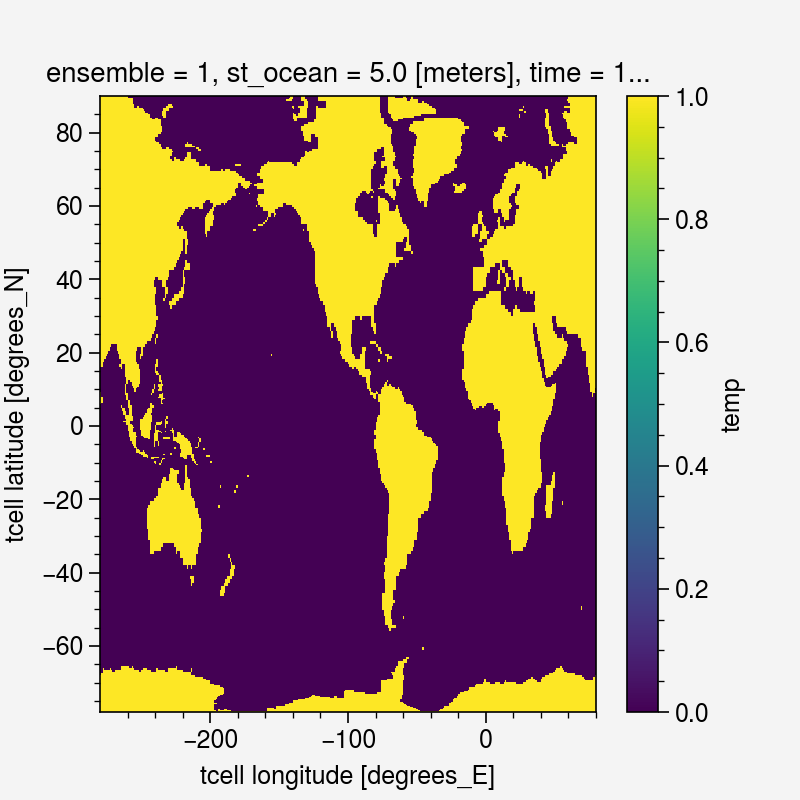

In [23]:
ds_CAFE60.temp.isel(st_ocean=0,time=0,ensemble=0).isnull().plot()

# Let's replace S2 "pure zero" with NaN

In [42]:
def replace_zero_w_nan(data_w_zero):
    data_w_nan = data_w_zero.where(data_w_zero != 0)
    data_w_nan.attrs['post_processing_note'] = 'zero values replaced with NaNs for land mask'
    return data_w_nan

In [43]:
data_w_zero = ds_S2_Tgrid.temp

In [44]:
data_w_nan = replace_zero_w_nan(data_w_zero)

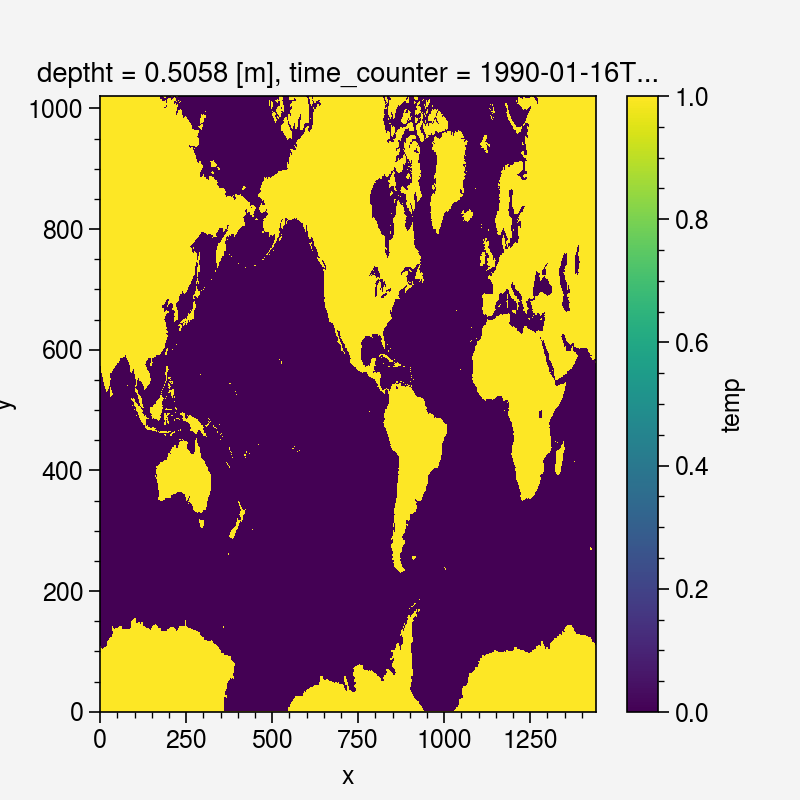

In [45]:
data_w_nan.isel(time_counter=0,deptht=0).isnull().plot()

In [46]:
data_w_nan

<xarray.DataArray 'temp' (time_counter: 12, deptht: 75, y: 1021, x: 1442)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat       (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.02 50.0 50.0
    nav_lon       (y, x) float32 72.75 73.0 73.25 73.5 ... 73.01 73.01 73.0 73.0
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 1990-...
Dimensions without coordinates: y, x
Attributes:
    units:                 degC
    standard_name:         sea_water_potential_temperature
    long_name:             Temperature
    online_operation:      ave(X)
    interval_operation:    1350.0
    interval_write:        86400.0
    cell_measures:         area: areat
    cell_methods:          time_counter: mean
    post_processing_note:  zero values replaced with NaNs for land mask

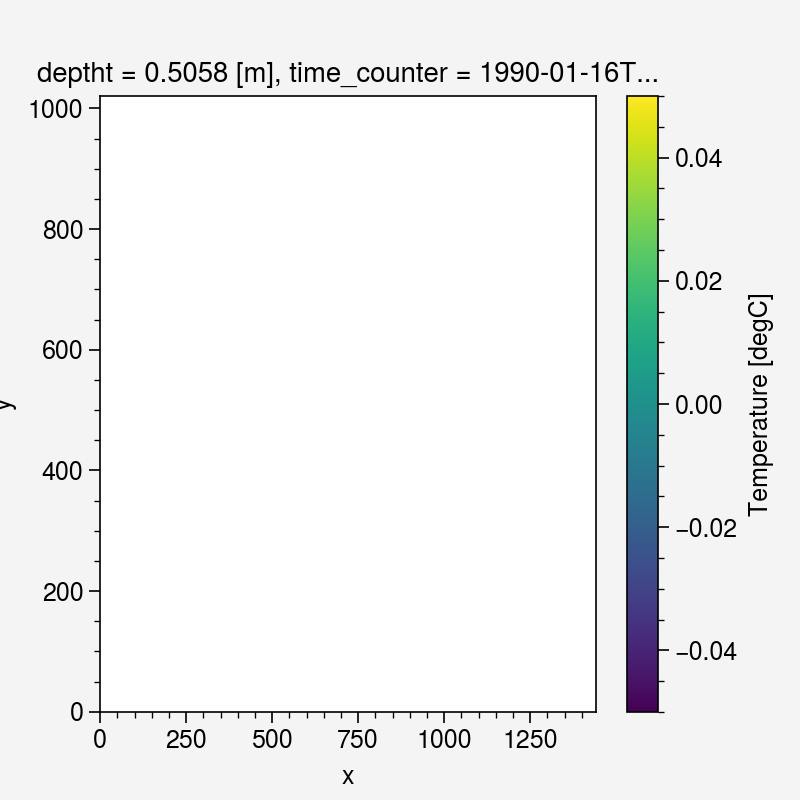

In [50]:
data_w_nan.isel(deptht=0,time_counter=0).where(data_w_nan.isel(deptht=0,time_counter=0)==0).plot()

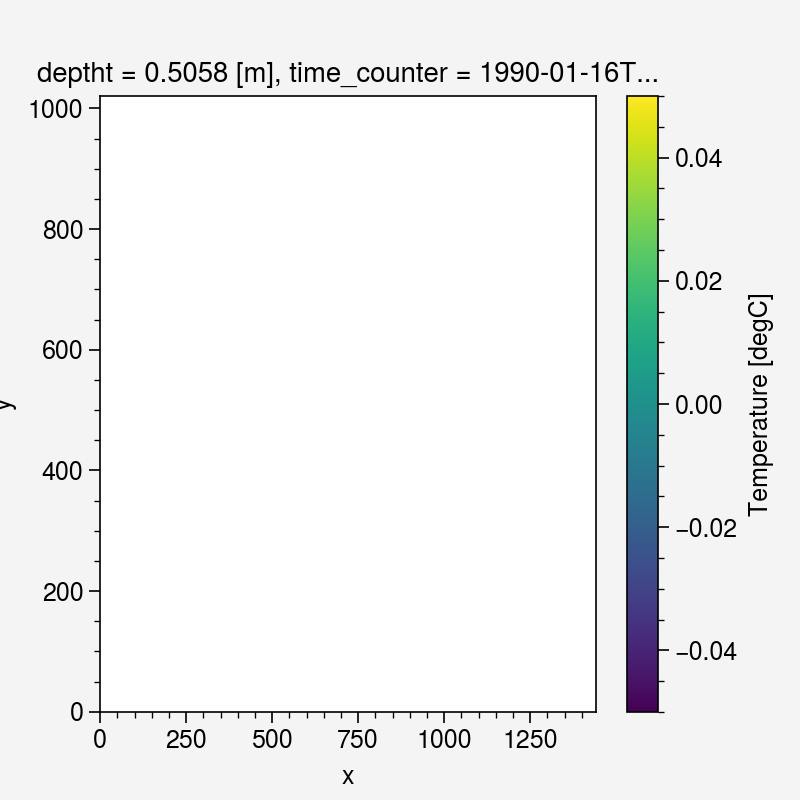

In [51]:
helper.replace_zero_w_nan(data_w_zero).isel(deptht=0,time_counter=0).where(data_w_nan.isel(deptht=0,time_counter=0)==0).plot()

In [52]:
data_w_nan

<xarray.DataArray 'temp' (time_counter: 12, deptht: 75, y: 1021, x: 1442)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat       (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.02 50.0 50.0
    nav_lon       (y, x) float32 72.75 73.0 73.25 73.5 ... 73.01 73.01 73.0 73.0
  * time_counter  (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 1990-...
Dimensions without coordinates: y, x
Attributes:
    units:                 degC
    standard_name:         sea_water_potential_temperature
    long_name:             Temperature
    online_operation:      ave(X)
    interval_operation:    1350.0
    interval_write:        86400.0
    cell_measures:         area: areat
    cell_methods:          time_counter: mean
    post_processing_note:  zero values replaced with NaNs for land mask

In [53]:
helper.replace_zero_w_nan(ds_S2_Tgrid)

<xarray.Dataset>
Dimensions:            (y: 1021, x: 1442, deptht: 75, ndepth_bounds: 2, ncorners: 4, time_counter: 12, tbnds: 2)
Coordinates:
  * deptht             (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 -77.01 -77.01 -77.01 ... 50.02 50.0 50.0
    nav_lon            (y, x) float32 72.75 73.0 73.25 73.5 ... 73.01 73.0 73.0
  * time_counter       (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners, tbnds
Data variables:
    areat              (y, x) float32 3.905e+07 3.905e+07 ... 6.769e+04 445.7
    deptht_bounds      (deptht, ndepth_bounds) float32 nan 1.024 ... 6.004e+03
    latt_bounds        (y, x, ncorners) float32 -77.04 -77.04 ... 49.99 49.99
    lont_bounds        (y, x, ncorners) float32 72.62 72.88 72.88 ... 73.0 73.0
    temp               (time_counter, deptht, y, x) float32 nan nan ... nan nan
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] 1990-01-16 ... 19...
Attributes:
    Conventions:           CF-1.6
    production:            An IPSL model
    TimeStamp:             07/04/2019 21:31:18 -0000
    NCO:                   netCDF Operators version 4.9.2 (Homepage = http://...
    history:               Tue Jun 15 16:48:41 AEST 2021: File created using ...
    post_processing_note:  zero values replaced with NaNs for land mask

# $\big\Downarrow$ This has been run on 7 Dec 2021

# SST

In [16]:
%%time
sst = ds_Tocean.sst
sst_025 = ds_025_Tocean.sst
sst.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SST.grid1deg.nc')
sst_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SST.nativegrid.nc')

CPU times: user 5.41 s, sys: 579 ms, total: 5.99 s
Wall time: 39.7 s


# SSS

In [17]:
%%time
sss = ds_Tocean.sss
sss_025 = ds_025_Tocean.sss
sss.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SSS.grid1deg.nc')
sss_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.SSS.nativegrid.nc')

CPU times: user 4.6 s, sys: 440 ms, total: 5.04 s
Wall time: 31.6 s


# mld1

In [18]:
%%time
mld1 = ds_Tocean.mld1
mld1_025 = ds_025_Tocean.mld1
mld1.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld1.grid1deg.nc')
mld1_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld1.nativegrid.nc')

CPU times: user 4.76 s, sys: 485 ms, total: 5.24 s
Wall time: 32.3 s


# mld2

In [19]:
%%time
mld2 = ds_Tocean.mld2
mld2_025 = ds_025_Tocean.mld2
mld2.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld2.grid1deg.nc')
mld2_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.mld2.nativegrid.nc')

CPU times: user 4.38 s, sys: 419 ms, total: 4.8 s
Wall time: 30.1 s


# td

In [20]:
%%time
td = ds_Tocean.td
td_025 = ds_025_Tocean.td
td.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.td.grid1deg.nc')
td_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.td.nativegrid.nc')

CPU times: user 4.1 s, sys: 419 ms, total: 4.51 s
Wall time: 30 s


# temp50

In [21]:
%%time
temp50 = ds_Tocean.temp50
temp50_025 = ds_025_Tocean.temp50
temp50.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp50.grid1deg.nc')
temp50_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp50.nativegrid.nc')

CPU times: user 4.48 s, sys: 437 ms, total: 4.91 s
Wall time: 30.2 s


# temp100

In [22]:
%%time
temp100 = ds_Tocean.temp100
temp100_025 = ds_025_Tocean.temp100
temp100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp100.grid1deg.nc')
temp100_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp100.nativegrid.nc')

CPU times: user 4.62 s, sys: 450 ms, total: 5.07 s
Wall time: 31.2 s


# temp200

In [23]:
%%time
temp200 = ds_Tocean.temp200
temp200_025 = ds_025_Tocean.temp200
temp200.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp200.grid1deg.nc')
temp200_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp200.nativegrid.nc')

CPU times: user 4.55 s, sys: 499 ms, total: 5.05 s
Wall time: 32.3 s


# temp500

In [24]:
%%time
temp500 = ds_Tocean.temp500
temp500_025 = ds_025_Tocean.temp500
temp500.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp500.grid1deg.nc')
temp500_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.temp500.nativegrid.nc')

CPU times: user 4.67 s, sys: 456 ms, total: 5.13 s
Wall time: 33.3 s


# temp sanity checks

In [22]:
#build datasets
temp_1deg = xr.merge([temp50,temp100,temp200,temp500])
temp_025 = xr.merge([temp50_025,temp100_025,temp200_025,temp500_025])

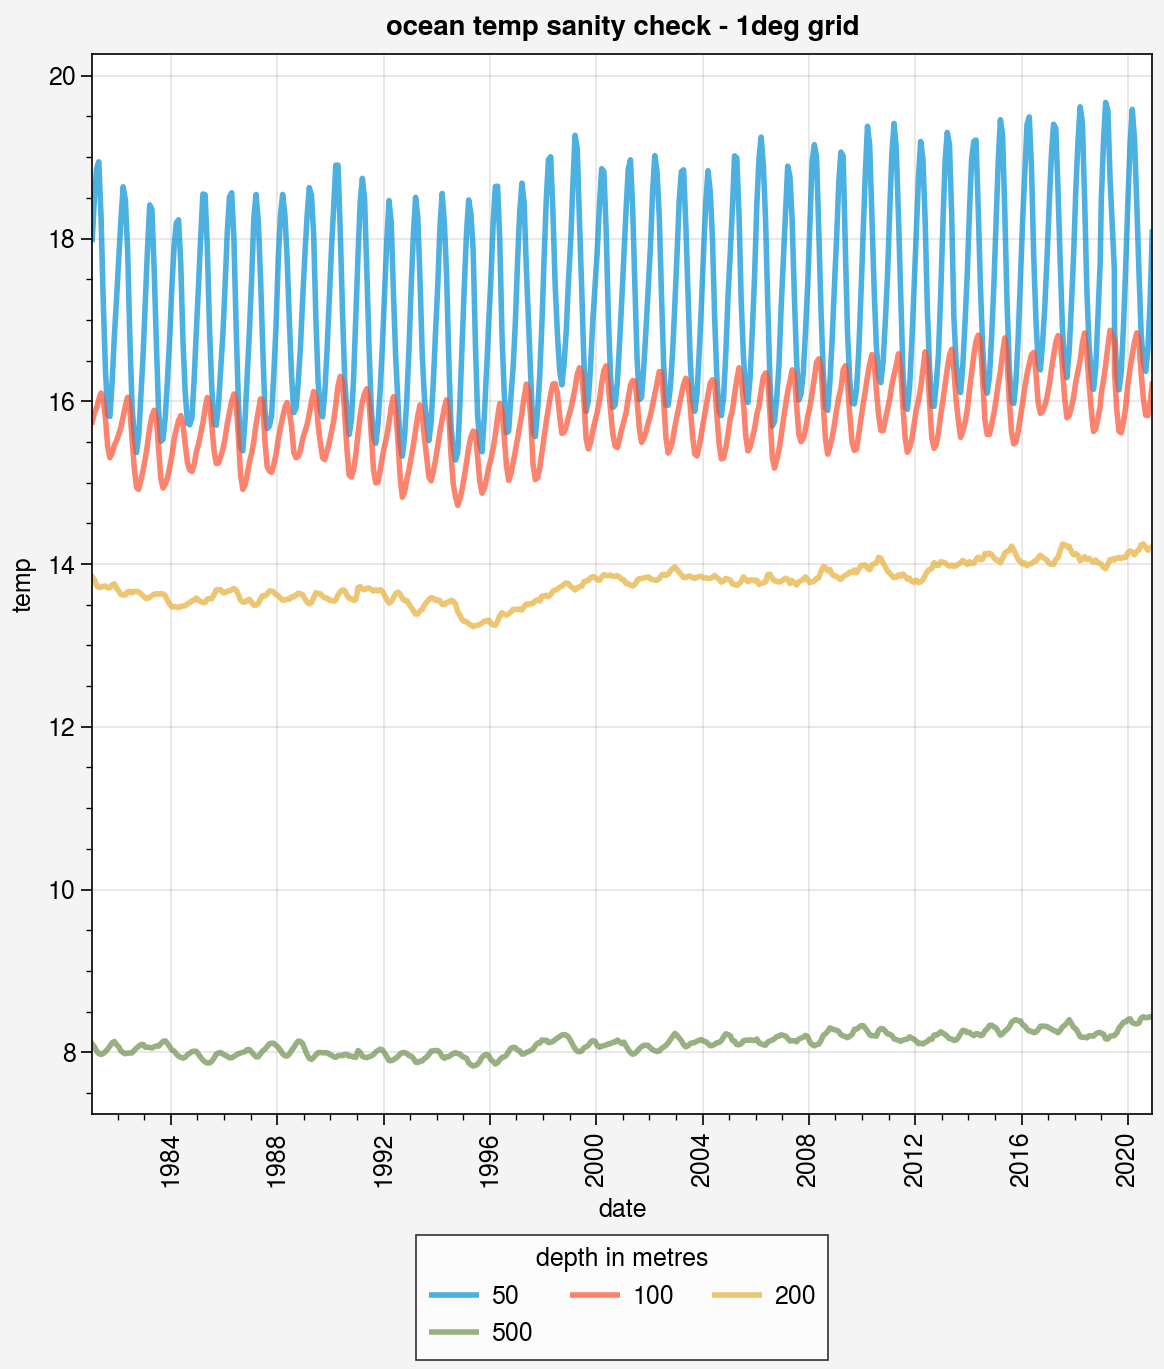

In [23]:
import proplot as pplt
import numpy as np
pplt.rc.cycle = '538'
fig, axs = pplt.subplots(ncols=1, span=False, share='labels', refwidth=5.3)
labels = ['50', '100', '200', '500']
hs1 = []
region = {'lat':slice(-50,-15),'lon':slice(150,180)}
for i, label in enumerate(labels):
    var_string = 'temp'+label
    data = temp_1deg[var_string].sel(region).mean({'lat','lon'})
    h1 = axs[0].plot(
        data, lw=2, label=label, alpha=0.7
    )
    hs1.extend(h1)

# Outer legends
ax = axs[0]
ax.legend(hs1, loc='b', ncols=3, title='depth in metres', order='C', facecolor='gray2')
axs.format(xlabel='date', ylabel='temp', suptitle='ocean temp sanity check - 1deg grid')

KeyError: 'no index found for coordinate lat'

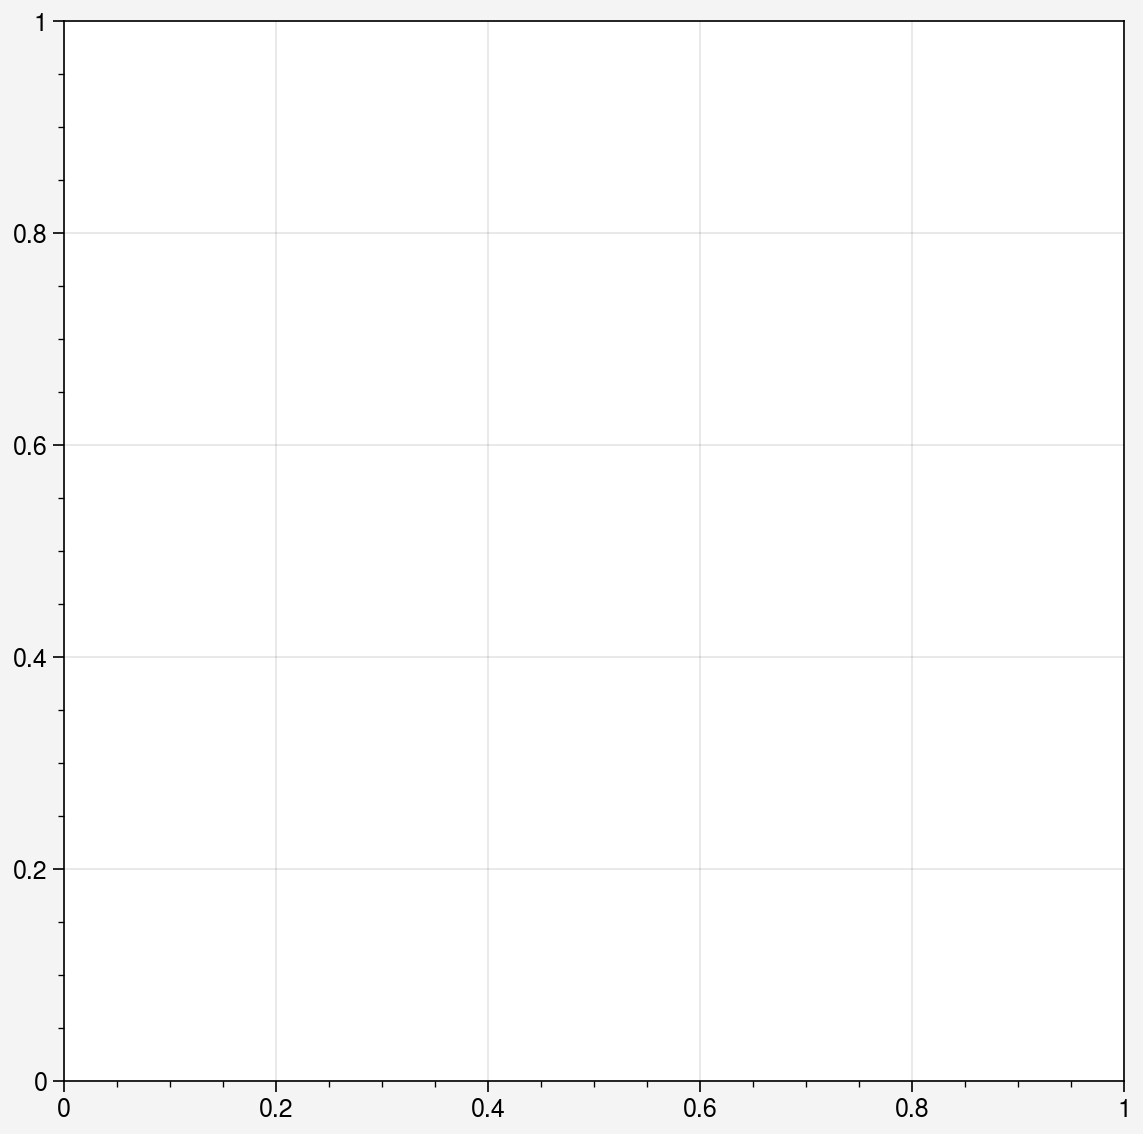

In [24]:
import proplot as pplt
import numpy as np
pplt.rc.cycle = '538'
fig, axs = pplt.subplots(ncols=1, span=False, share='labels', refwidth=5.3)
labels = ['50', '100', '200', '500']
hs1 = []
region = {'lat':slice(-50,-15),'lon':slice(150,180)}
for i, label in enumerate(labels):
    var_string = 'temp'+label
    data = temp_025[var_string].sel(region).mean({'lat','lon'})
    h1 = axs[0].plot(
        data, lw=2, label=label, alpha=0.7
    )
    hs1.extend(h1)

# Outer legends
ax = axs[0]
ax.legend(hs1, loc='b', ncols=3, title='depth in metres', order='C', facecolor='gray2')
axs.format(xlabel='date', ylabel='temp', suptitle='ocean temp sanity check - 0.25deg grid')

In [25]:
temp500_025

<xarray.DataArray 'temp500' (time: 480, y: 1021, x: 1442)>
dask.array<open_dataset-a59030bdc8979d64682f83a4f08d954dtemp500, shape=(480, 1021, 1442), dtype=float32, chunksize=(12, 1021, 1442), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
Dimensions without coordinates: y, x
Attributes:
    cell_measures:       area: areat
    cell_methods:        time_counter: mean
    coordinates:         deptht nav_lat nav_lon
    interval_operation:  1350.0
    interval_write:      86400.0
    long_name:           Temperature
    online_operation:    ave(X)
    standard_name:       sea_water_potential_temperature
    units:               degC

# U100

In [25]:
%%time
u100 = ds_u.u.sel(depth=100,method='nearest')
u100_025 = ds_025_u.u.sel(depth=100,method='nearest')
u100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100.grid1deg.nc')
u100_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100.nativegrid.nc')

CPU times: user 28.2 s, sys: 2.77 s, total: 31 s
Wall time: 4min 20s


# V100

In [26]:
%%time
v100 = ds_v.v.sel(depth=100,method='nearest')
v100_025 = ds_025_v.v.sel(depth=100,method='nearest')
v100.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100.grid1deg.nc')
v100_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100.nativegrid.nc')

CPU times: user 29.5 s, sys: 2.87 s, total: 32.4 s
Wall time: 4min 28s


# D20

In [27]:
%%time
d20 = ds_Tocean.d20
d20_025 = ds_025_Tocean.d20
d20.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.d20.grid1deg.nc')
d20_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.d20.nativegrid.nc')

CPU times: user 4.62 s, sys: 408 ms, total: 5.03 s
Wall time: 30.6 s


# hc300

In [28]:
%%time
hc300 = ds_Tocean.hc300
hc300_025 = ds_025_Tocean.hc300
hc300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.hc300.grid1deg.nc')
hc300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.hc300.nativegrid.nc')

CPU times: user 4.46 s, sys: 442 ms, total: 4.9 s
Wall time: 29.6 s


# u100_300

## need to use depth weighted mean

In [29]:
%%time
u100_300 = helper.weighted_ocean_mean(ds_u.u,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
u100_300_025 = helper.weighted_ocean_mean(ds_025_u.u,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
u100_300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100_300.grid1deg.nc')
u100_300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.u100_300.nativegrid.nc')

CPU times: user 46.7 s, sys: 4.07 s, total: 50.8 s
Wall time: 4min 42s


# v100_300

## need to use depth weighted mean

In [30]:
%%time
v100_300 = helper.weighted_ocean_mean(ds_v.v,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
v100_300_025 = helper.weighted_ocean_mean(ds_025_v.v,weights=depth_weights,dim='depth',sel_dict={'depth':slice(100,300)})
v100_300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100_300.grid1deg.nc')
v100_300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.v100_300.nativegrid.nc')

CPU times: user 47.6 s, sys: 4.17 s, total: 51.8 s
Wall time: 4min 40s


# EKE_300

## need to account for variable cell thickness without formal integration

In [31]:
eke = ds_KE.EKE
eke_025 = ds_025_KE.EKE

In [32]:
eke300 = (eke * depth_weights).sel(depth=slice(0,300)).sum('depth',skipna=False)
eke300_025 = (eke_025 * depth_weights).sel(depth=slice(0,300)).sum('depth',skipna=False)

In [33]:
%%time
eke300.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke300.grid1deg.nc')
eke300_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke300.nativegrid.nc')

CPU times: user 53.8 s, sys: 4.76 s, total: 58.5 s
Wall time: 4min 44s


# EKE_2000

## need to account for variable cell thickness without formal integration

In [34]:
eke2000 = (eke * depth_weights).sel(depth=slice(0,2000)).sum('depth',skipna=False)
eke2000_025 = (eke_025 * depth_weights).sel(depth=slice(0,2000)).sum('depth',skipna=False)

In [35]:
%%time
eke2000.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke2000.grid1deg.nc')
eke2000_025.to_netcdf('/g/data/v14/tm4888/data/ACCESS-S2/ETBF_export/accessS2.RA.eke2000.nativegrid.nc')

CPU times: user 1min 10s, sys: 5.89 s, total: 1min 16s
Wall time: 5min 9s


# $\big\Uparrow$ This has been run on 7 December 2021

# setup regridder using `xesmf`

In [25]:
u = u.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
v = v.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

## curvilinear grid

In [26]:
nav_lon = u['lon'].compute()
nav_lat = u['lat'].compute()

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [28]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

# U

In [35]:
u = u.chunk({'y':1021, 'x':1442}) #xesmf hates chunks across grid vars?

In [36]:
%%time
regridder_S2_1deg_Ugrid = xe.Regridder(u, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

CPU times: user 1min, sys: 1.82 s, total: 1min 2s
Wall time: 1min 8s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [38]:
%%time
regridder_S2_1deg_Ugrid._grid_in = None
regridder_S2_1deg_Ugrid._grid_out = None
ds_ACCESS_S2_RA_ocean_u_1degRegrid = regridder_S2_1deg_Ugrid(u)

CPU times: user 252 ms, sys: 1.64 ms, total: 254 ms
Wall time: 246 ms


In [39]:
ds_ACCESS_S2_RA_ocean_u_1degRegrid

<xarray.Dataset>
Dimensions:  (time: 480, depth: 75, y: 180, x: 360)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    u        (time, depth, y, x) float32 dask.array<chunksize=(480, 1, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# V

In [41]:
v = v.chunk({'y':1021, 'x':1442}) #xesmf hates chunks across grid vars?

In [42]:
%%time
regridder_S2_1deg_Vgrid = xe.Regridder(v, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

CPU times: user 1min 4s, sys: 2.02 s, total: 1min 6s
Wall time: 1min 13s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [46]:
%%time
regridder_S2_1deg_Vgrid._grid_in = None
regridder_S2_1deg_Vgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_v_1degRegrid = regridder_S2_1deg_Vgrid(v)

CPU times: user 258 ms, sys: 2.75 ms, total: 260 ms
Wall time: 251 ms


In [47]:
ds_ACCESS_S2_RA_ocean_v_1degRegrid

<xarray.Dataset>
Dimensions:  (time: 480, depth: 75, y: 180, x: 360)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    v        (time, depth, y, x) float32 dask.array<chunksize=(480, 1, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [51]:
ds_ACCESS_S2_RA_ocean_v_1degRegrid = ds_ACCESS_S2_RA_ocean_v_1degRegrid.assign_coords(
    {'x': ds_ACCESS_S2_RA_ocean_v_1degRegrid.lon.isel(y=0),
    'y': ds_ACCESS_S2_RA_ocean_v_1degRegrid.lat.isel(x=0)}).drop(
    ['lon','lat']).rename({'x':'lon','y':'lat'})

In [52]:
ds_ACCESS_S2_RA_ocean_u_1degRegrid = ds_ACCESS_S2_RA_ocean_u_1degRegrid.assign_coords(
    {'x': ds_ACCESS_S2_RA_ocean_u_1degRegrid.lon.isel(y=0),
    'y': ds_ACCESS_S2_RA_ocean_u_1degRegrid.lat.isel(x=0)}).drop(
    ['lon','lat']).rename({'x':'lon','y':'lat'})

# write out the 1deg u & v zarr collections

In [53]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.regrid_1deg.zarr
ds_ACCESS_S2_RA_ocean_u_1degRegrid.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.regrid_1deg.zarr',
                                           consolidated=True)

CPU times: user 37.4 s, sys: 3.28 s, total: 40.7 s
Wall time: 2min 34s


In [54]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.regrid_1deg.zarr
ds_ACCESS_S2_RA_ocean_v_1degRegrid.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.regrid_1deg.zarr',
                                           consolidated=True)

CPU times: user 35.3 s, sys: 3.15 s, total: 38.4 s
Wall time: 2min 28s


# Load 1deg U&V

In [56]:
ds_u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.regrid_1deg.zarr')
ds_v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.regrid_1deg.zarr')

In [57]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [58]:
u_da = ds_u.u
v_da = ds_v.v

In [59]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

CPU times: user 57.2 ms, sys: 5.95 ms, total: 63.2 ms
Wall time: 164 ms


/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [60]:
KE = xr.merge([EKE,MKE])

In [85]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.regrid_1deg.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.regrid_1deg.zarr',consolidated=True)

CPU times: user 4.72 s, sys: 415 ms, total: 5.13 s
Wall time: 13.2 s


# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7fcb04415430>>, <Task finished name='Task-304880' coro=<Scheduler.restart() done, defined at /g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/scheduler.py:5885> exception=CommClosedError("Exception while trying to call remote method 'restart' before comm was established.")>)
Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/core.py", line 819, in send_recv_from_rpc
    result = awa

In [30]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()

# SST, SSS, MLD1-2,d20,HC300,td

### load the whole timeseries using `drop` preproccessor

In [ ]:
%%time
ds_SST_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True,preprocess=drop_not_in_2015)
#ds_SST_1981_2018 = xr.open_mfdataset(
#    [f'/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_{x}.nc' for x in range(year_start, year_end)],parallel=True,preprocess=drop_not_in_2015
#)

In [ ]:
%%time
ds_SSS_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_mld1_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_mld2_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_D20_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_hc300_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_td_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
%%time
ds_temp_1981_2018 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True,preprocess=drop_not_in_2015)

In [ ]:
ds_temp50_1981_2018 = ds_temp_1981_2018.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100_1981_2018 = ds_temp_1981_2018.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200_1981_2018 = ds_temp_1981_2018.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500_1981_2018 = ds_temp_1981_2018.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

In [ ]:
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50_1981_2018.drop('deptht'),
                                  ds_temp100_1981_2018.drop('deptht'),
                                  ds_temp200_1981_2018.drop('deptht'),
                                  ds_temp500_1981_2018.drop('deptht'),
                                  ds_SST_1981_2018.squeeze(),
                                  ds_SSS_1981_2018.squeeze(),
                                  ds_mld1_1981_2018,
                                  ds_mld2_1981_2018,
                                  ds_D20_1981_2018,
                                  ds_hc300_1981_2018,
                                  ds_td_1981_2018
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

## add back in key metadata

In [ ]:
areat = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_2016.nc',parallel=True)).areat.to_dataset()
areau = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2016.nc',parallel=True)).areau.to_dataset()
areav = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2016.nc',parallel=True)).areav.to_dataset()

In [ ]:
ds_ACCESS_S2_RA_ocean = xr.combine_by_coords([ds_ACCESS_S2_RA_ocean,areat])
ds_ACCESS_S2_RA_ocean

# Deal with the same depth coordinates given two different names & rename time

In [ ]:
#ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'deptht':'depth','time_counter':'time'})
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

In [ ]:
ds_ACCESS_S2_RA_ocean.sst.isel(time=0).plot(size = 10)

In [ ]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

In [ ]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

# SAVE ocean tgrid zarr file

In [ ]:
%%time
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [12]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

CPU times: user 774 ms, sys: 83.8 ms, total: 858 ms
Wall time: 2.45 s


Text(0.5, 1.0, 'mld1')

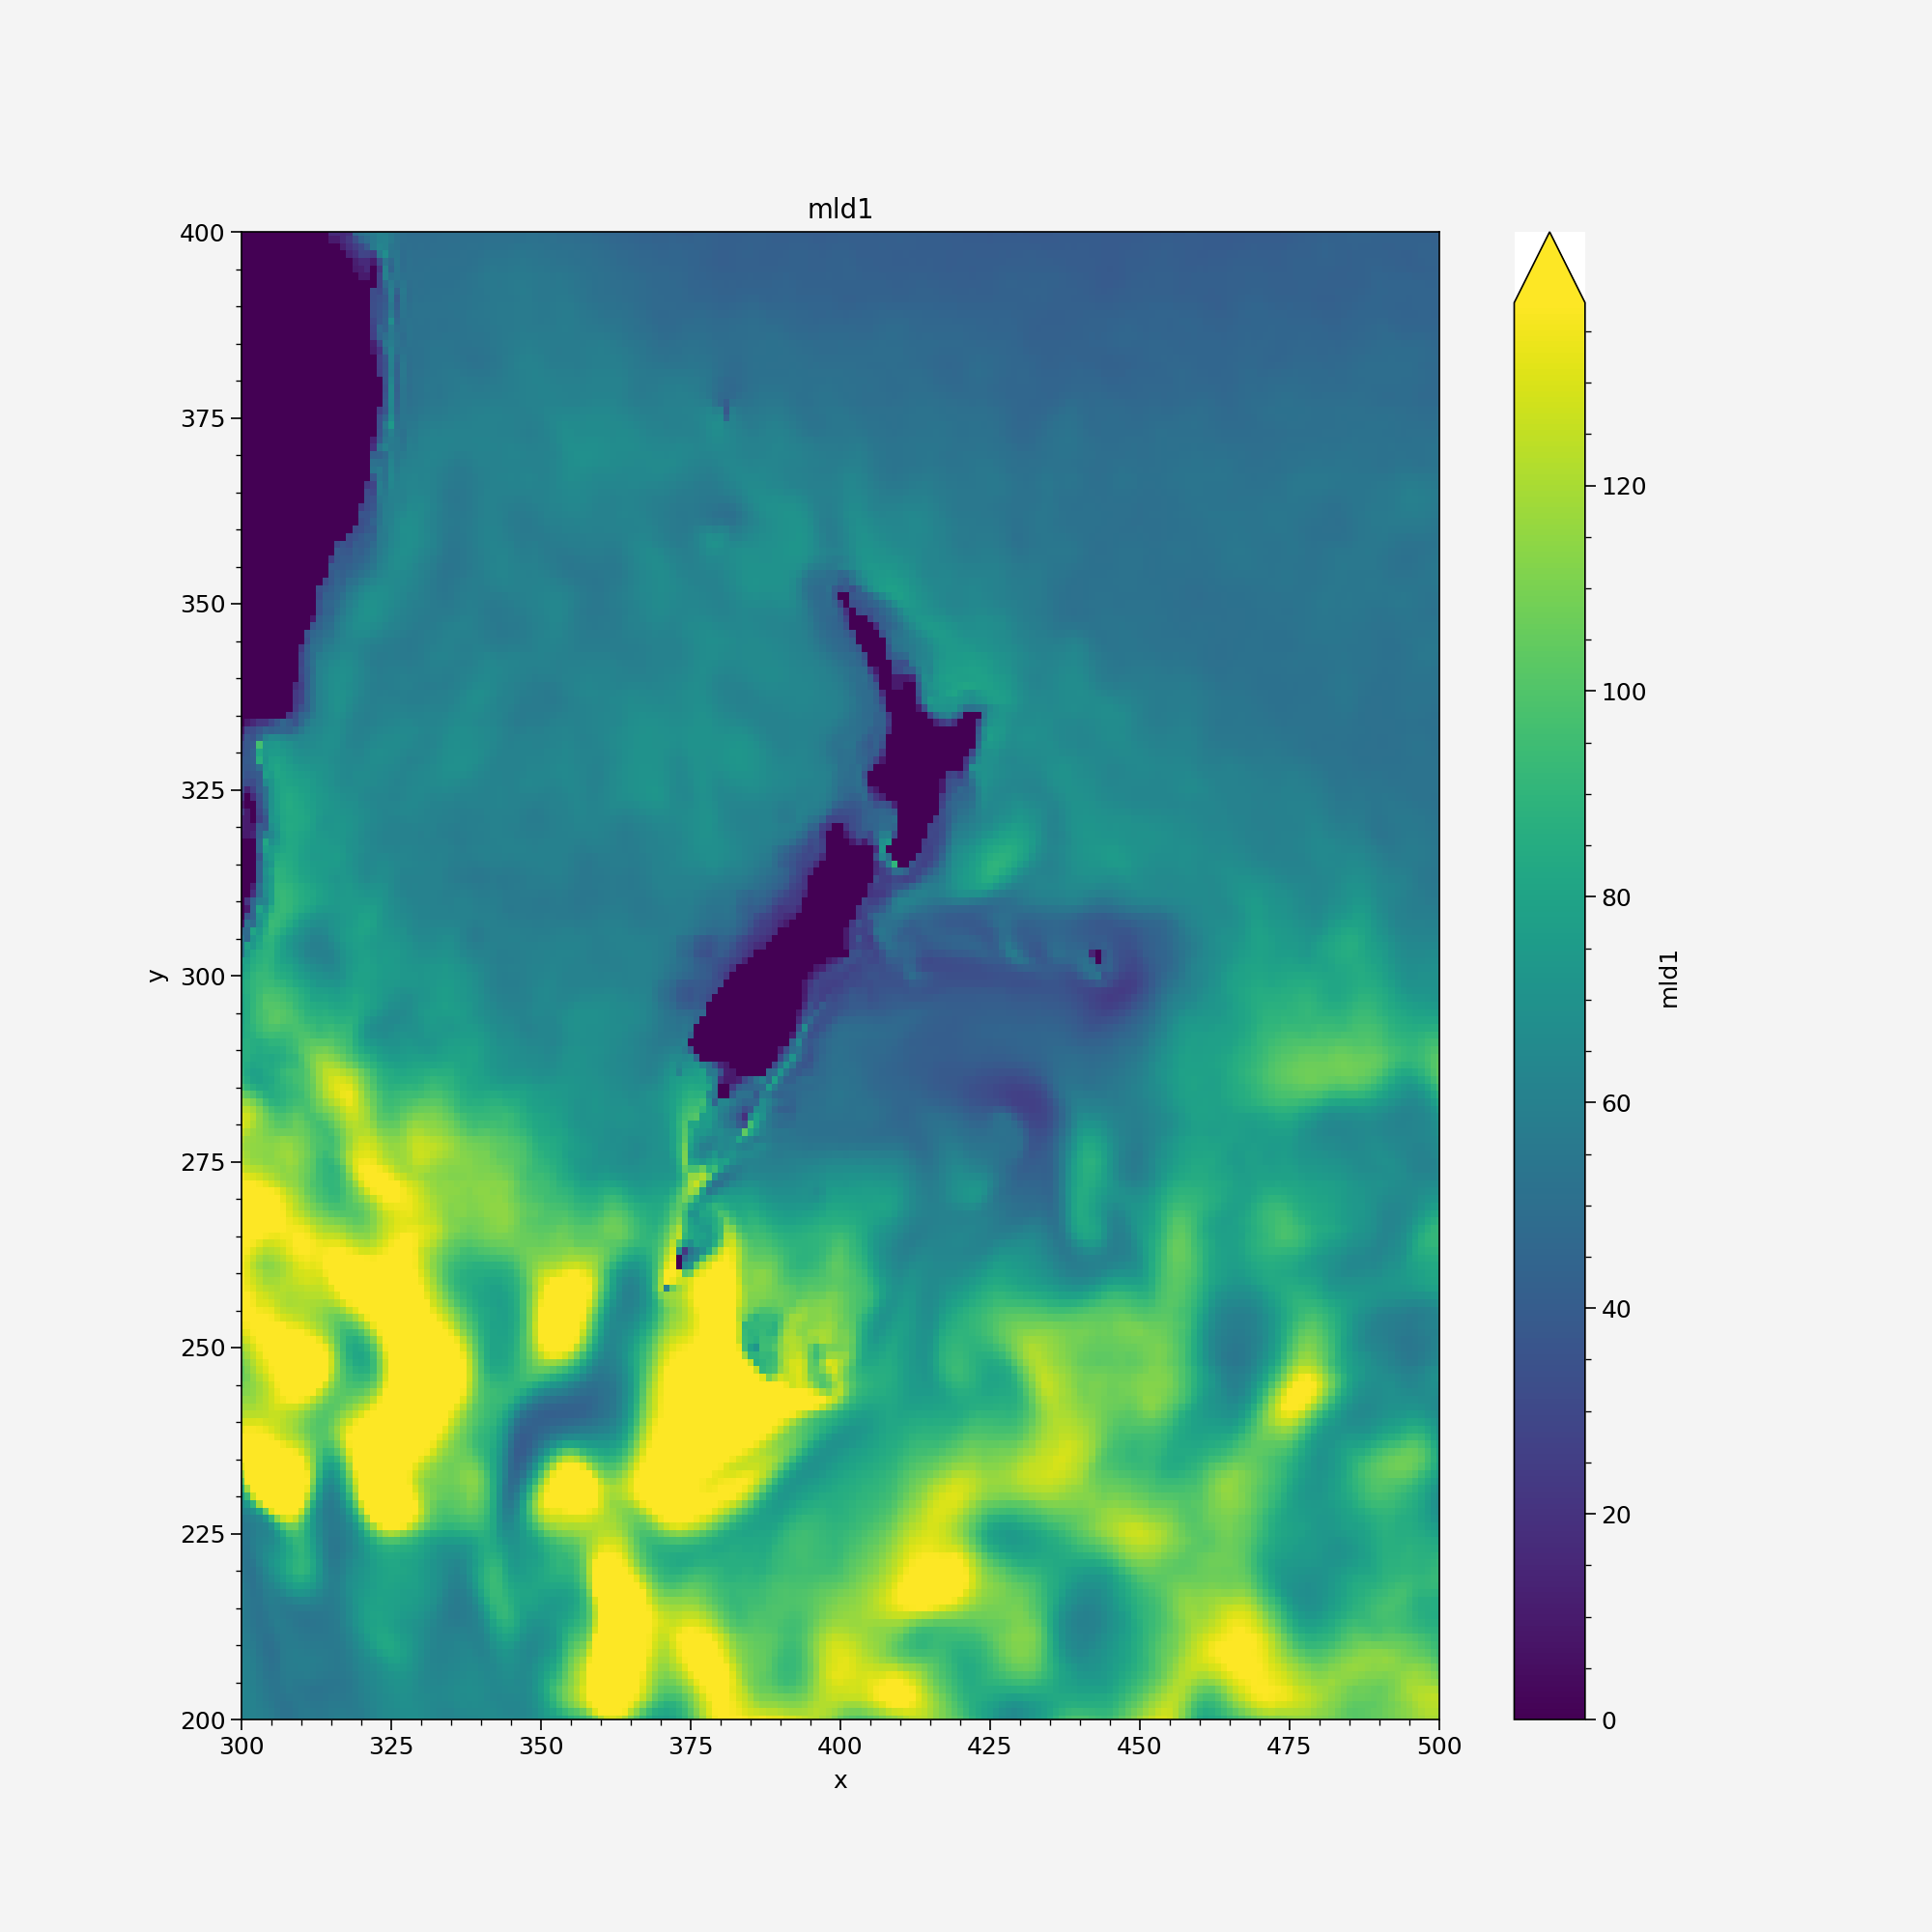

In [13]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('mld1')

# memory // 16GB plus 160GB on cluster

In [14]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

31.112267064

#### let's not persist this given crash on write
ds_ACCESS_S2_RA_ocean_nativeTgrid = ds_ACCESS_S2_RA_ocean_nativeTgrid.persist()

# Regridding Step

## curvilinear grid

In [15]:
nav_lon = ds_ACCESS_S2_RA_ocean_nativeTgrid['lon'].compute()
nav_lat = ds_ACCESS_S2_RA_ocean_nativeTgrid['lat'].compute()

Text(0.5, 1.0, 'ACCESS-S2 Curvilinear grid')

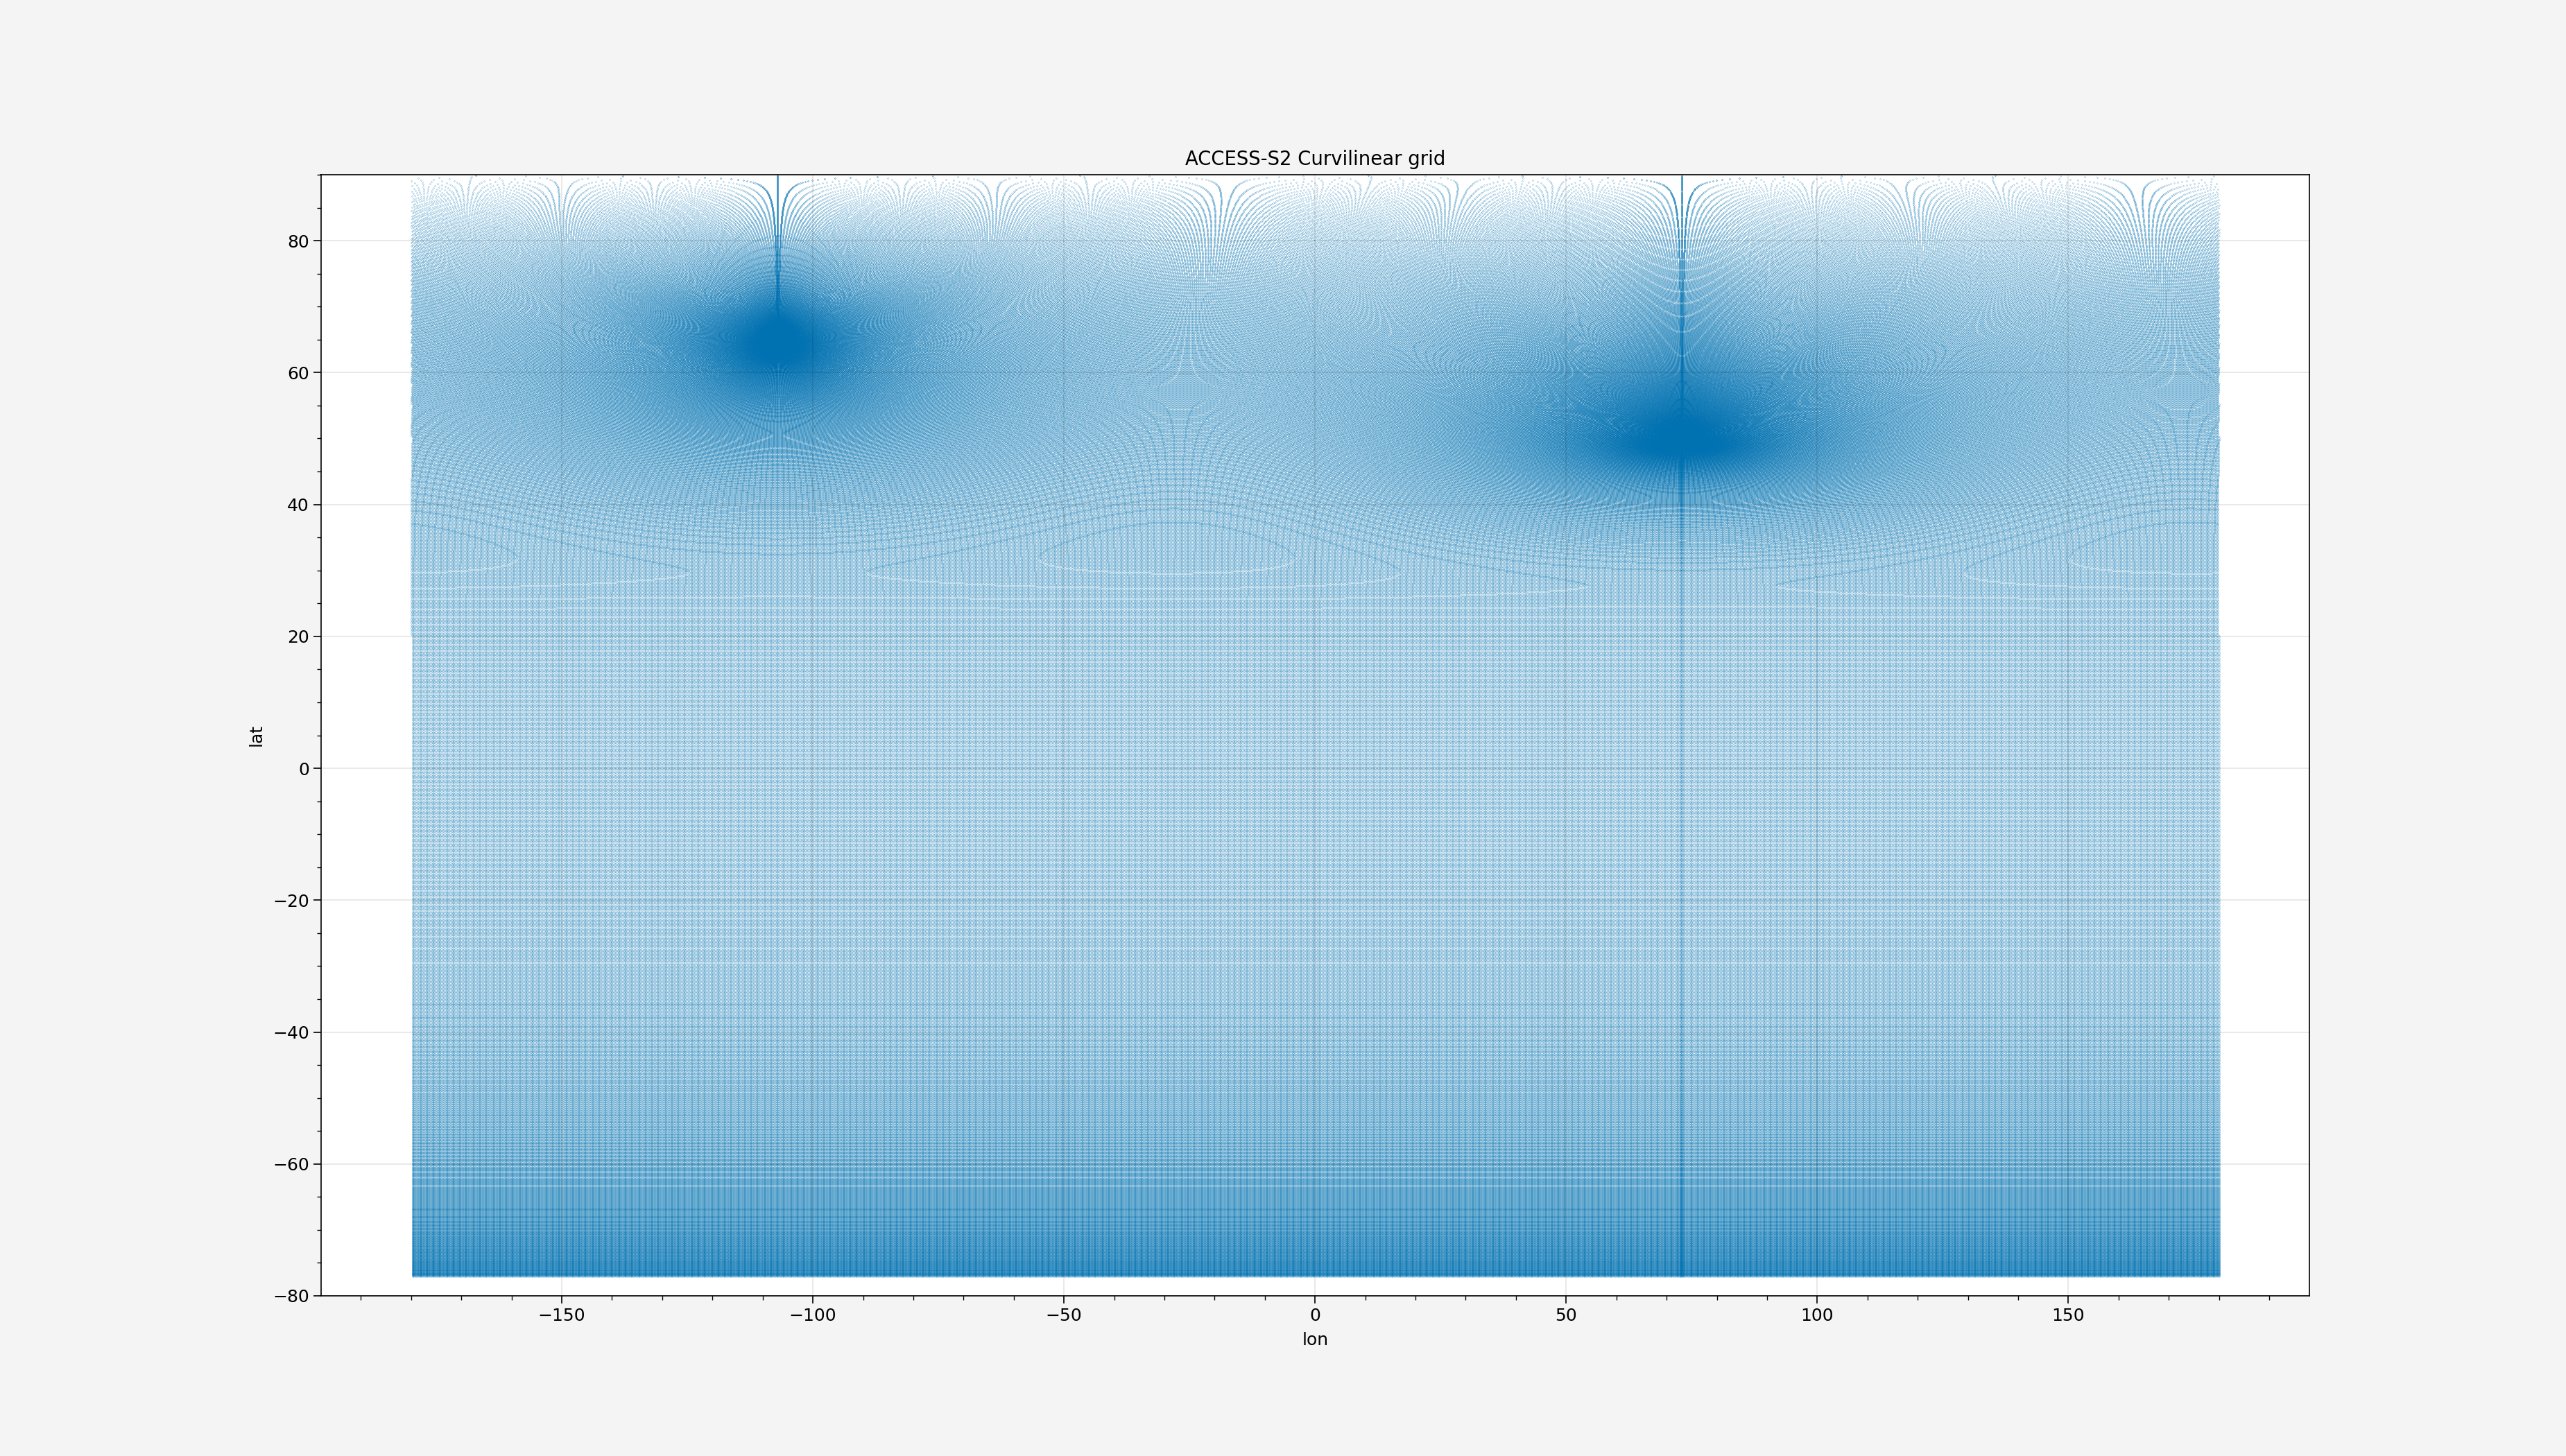

In [16]:
plt.scatter(nav_lon, nav_lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.ylim([-80, 90])
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('ACCESS-S2 Curvilinear grid')

# CHOOSE YOUR NEW GRID // define uniform 1x1 grid

In [17]:
new_1deg_grid = xe.util.grid_global(1, 1)
new_1deg_grid

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

Text(0.5, 1.0, 'uniform grid')

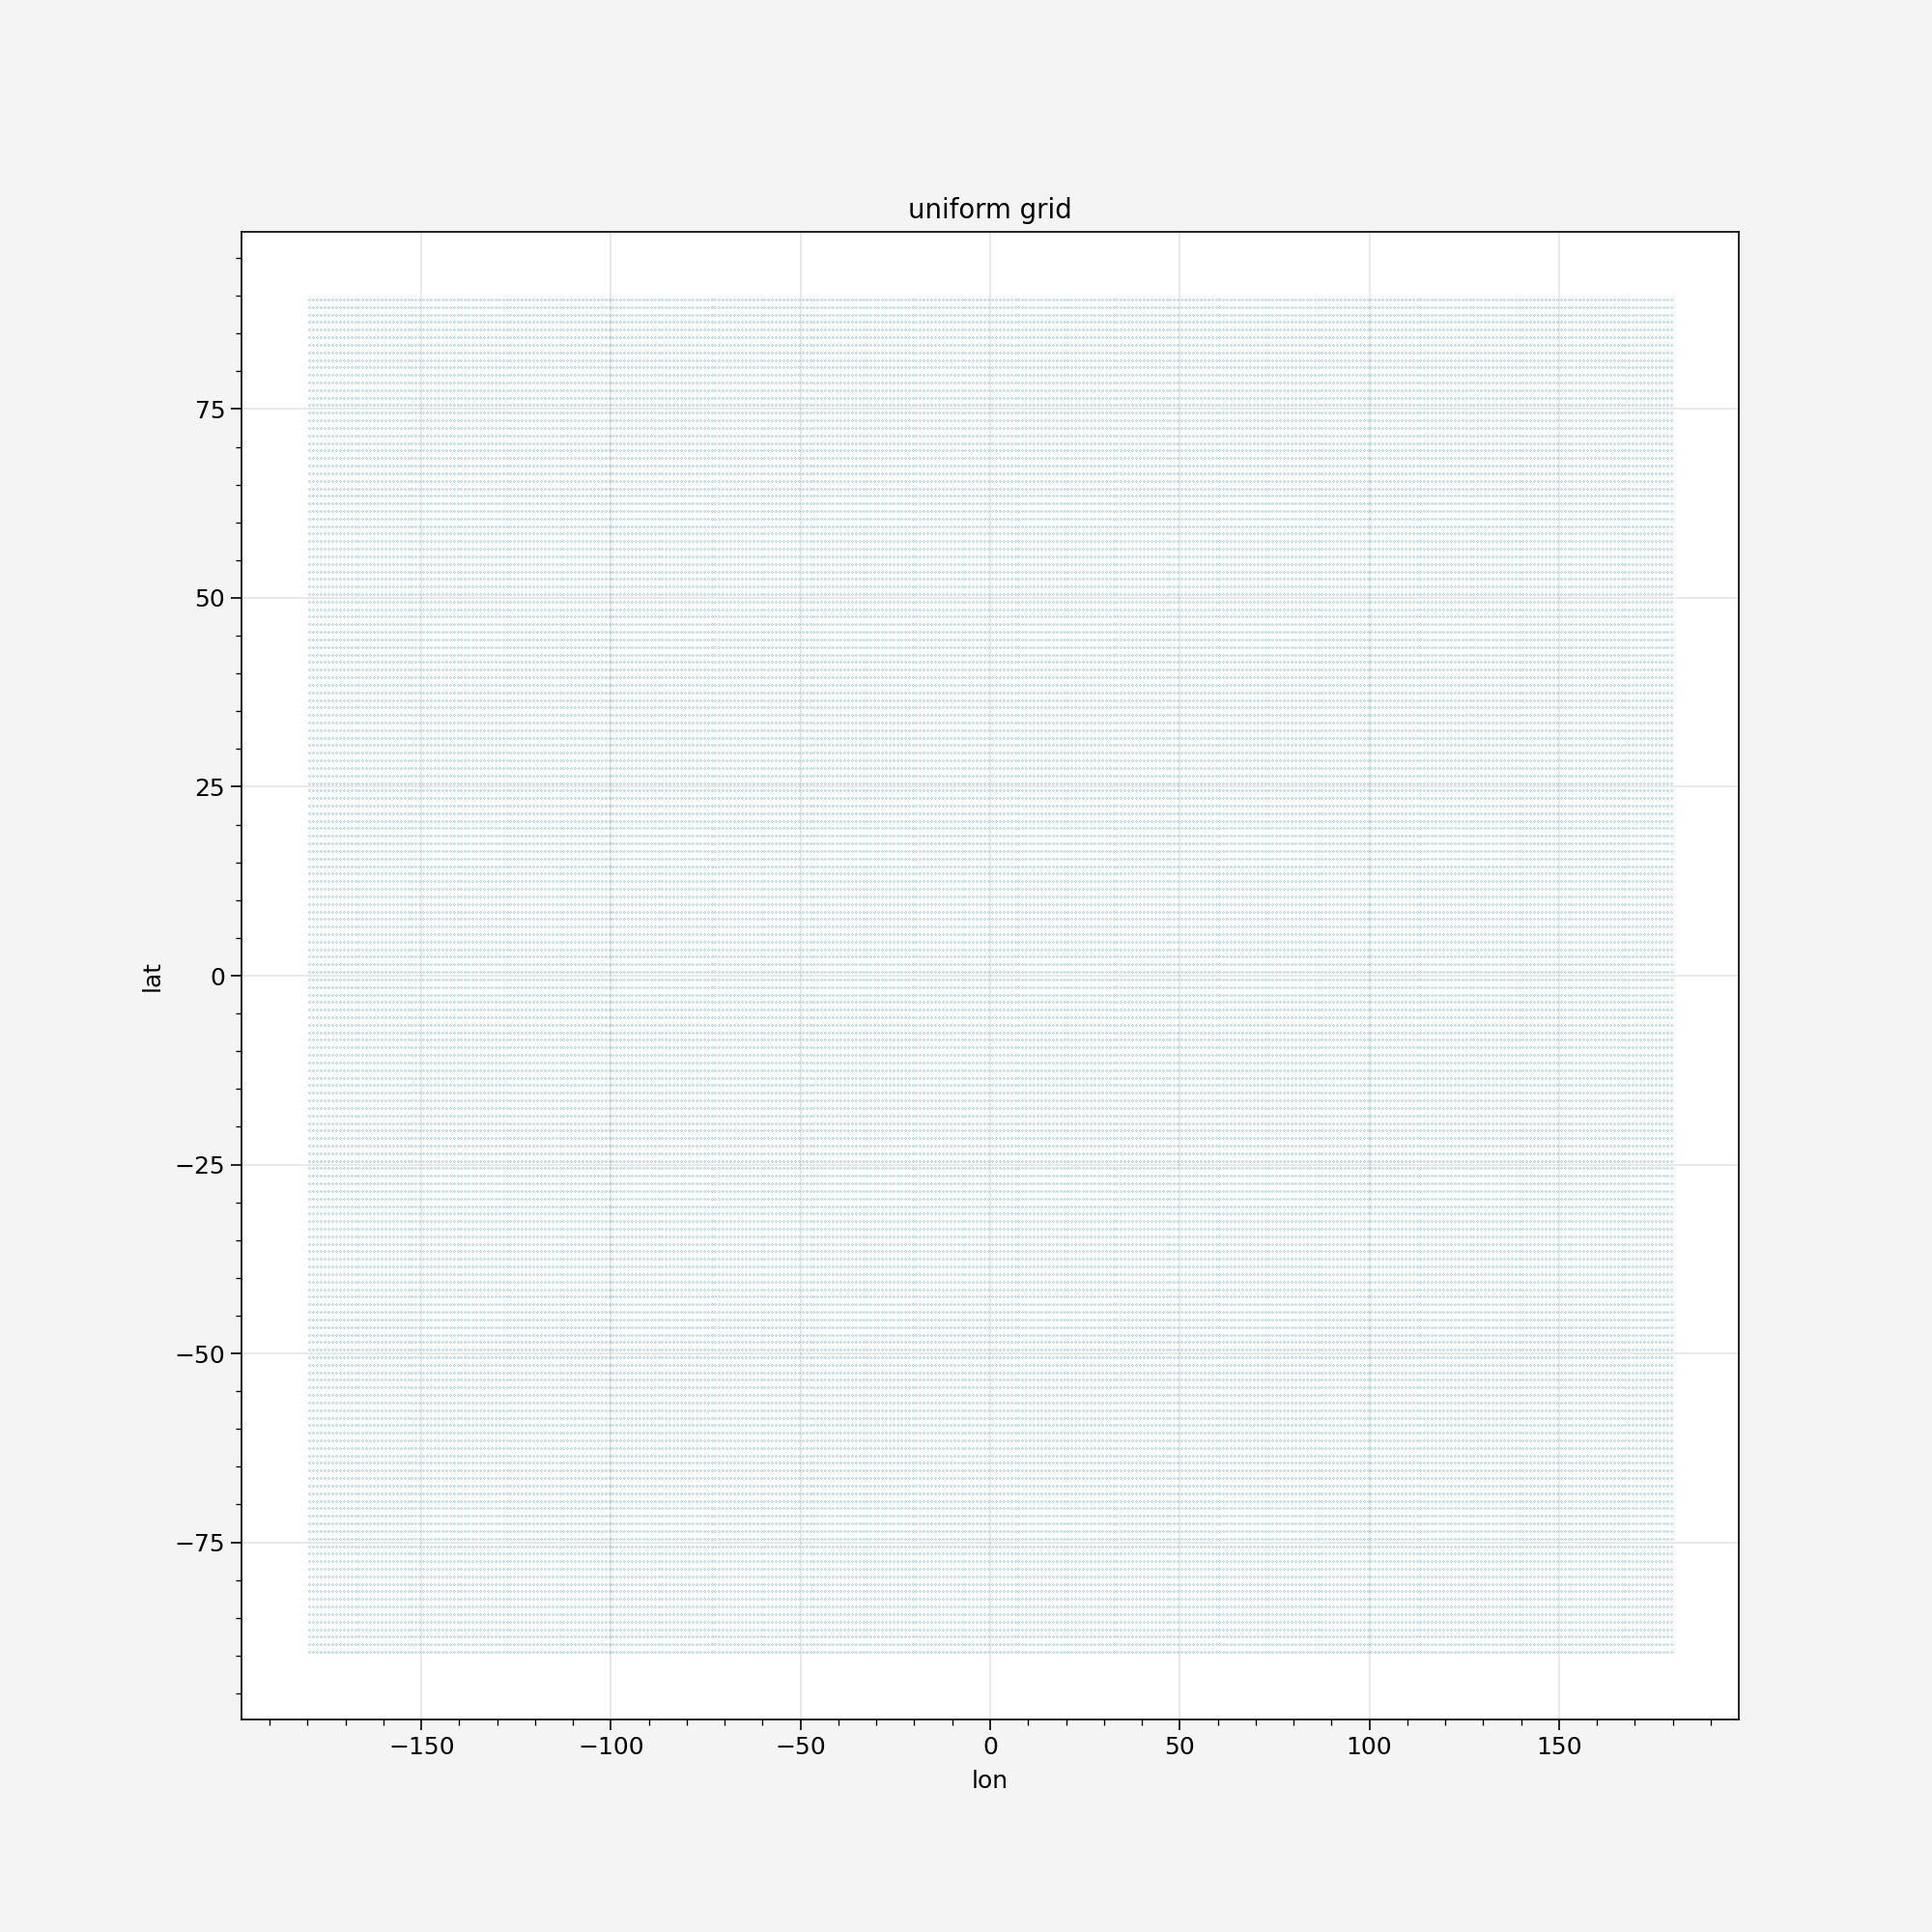

In [18]:
plt.scatter(new_1deg_grid.lon, new_1deg_grid.lat, s=0.01)  # plot grid locations
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('uniform grid')

In [19]:
%%time
regridder_S2_1deg_Tgrid = xe.Regridder(ds_ACCESS_S2_RA_ocean_nativeTgrid, new_1deg_grid,'bilinear', ignore_degenerate=True, periodic=True,reuse_weights=False)

CPU times: user 1min 3s, sys: 7.8 s, total: 1min 11s
Wall time: 1min 8s


## EARTH SYSTEM MODELLING FRAMEWORK (NCAR / NOAA) - https://en.wikipedia.org/wiki/Earth_System_Modeling_Framework </br></br>  xESMF // https://github.com/JiaweiZhuang/xESMF/blob/master/README.rst

## $\bigstar$ solution to parallel regridding issue = https://github.com/JiaweiZhuang/xESMF/issues/71

#### regrid the full dataset object

In [20]:
%%time
regridder_S2_1deg_Tgrid._grid_in = None
regridder_S2_1deg_Tgrid._grid_out = None
ds_ACCESS_S2_RA_ocean_1degRegrid = regridder_S2_1deg_Tgrid(ds_ACCESS_S2_RA_ocean_nativeTgrid)

CPU times: user 6.75 s, sys: 217 ms, total: 6.97 s
Wall time: 8.01 s


In [21]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: y, x
Data variables:
    areat    (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, y, x) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [22]:
ds_ACCESS_S2_RA_ocean_1degRegrid = ds_ACCESS_S2_RA_ocean_1degRegrid.assign_coords({'x': ds_ACCESS_S2_RA_ocean_1degRegrid.lon.isel(y=0),'y': ds_ACCESS_S2_RA_ocean_1degRegrid.lat.isel(x=0)}).drop(['lon','lat']).rename({'x':'lon','y':'lat'})

In [23]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    areat    (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [24]:
ds_ACCESS_S2_RA_ocean_1degRegrid.nbytes/1e9

1.36884336

## Sanity check

In [25]:
%%time
regrid_data = ds_ACCESS_S2_RA_ocean_1degRegrid.mld1.mean(dim='time').compute()
coarsened_data = ds_ACCESS_S2_RA_ocean_nativeTgrid.mld1.mean(dim='time')
coarsened_data = coarsened_data.coarsen({'x':4,'y':4}, boundary="trim").mean().compute()

CPU times: user 1.74 s, sys: 396 ms, total: 2.13 s
Wall time: 10.4 s


CPU times: user 218 ms, sys: 17.5 ms, total: 235 ms
Wall time: 227 ms


(36.0, 107.0)

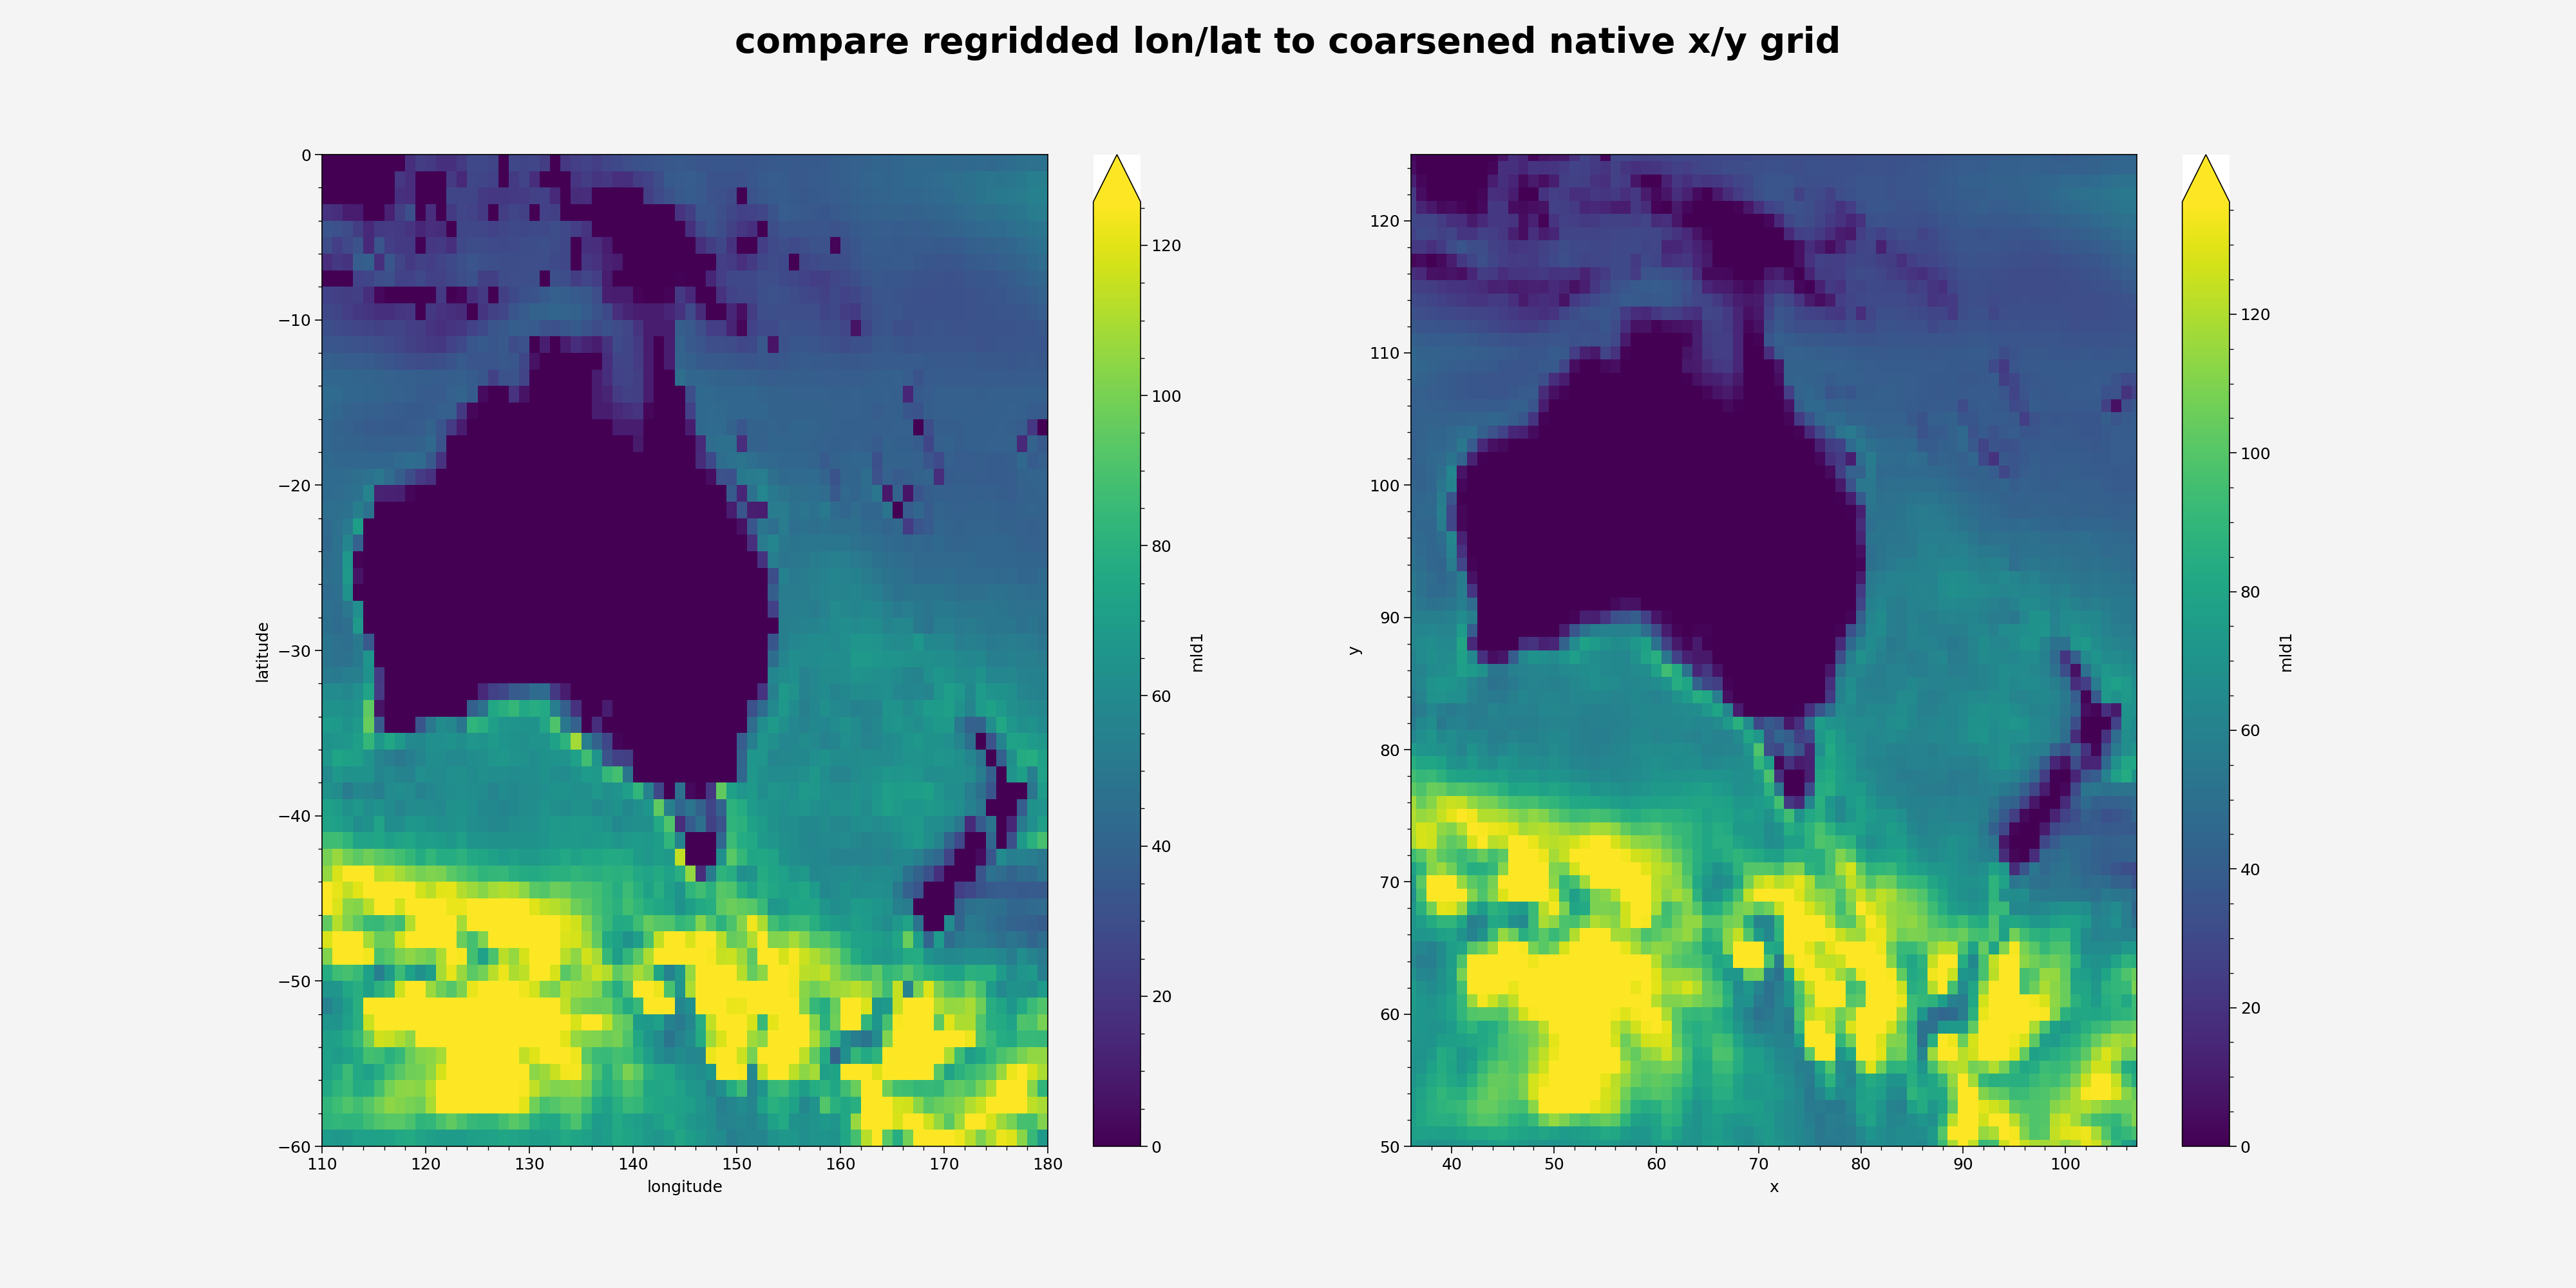

In [26]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('compare regridded lon/lat to coarsened native x/y grid',fontsize=20)
regrid_data.plot(robust=True,ax=ax1)
coarsened_data.plot(robust=True,ax=ax2)
ax1.set_ylim([-60,0])
ax1.set_xlim([110,180])
ax2.set_ylim([50,125])
ax2.set_xlim([36,107])

# write 1deg Tgrid file to zarr

In [27]:
ds_ACCESS_S2_RA_ocean_1degRegrid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    areat    (lat, lon) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    d20      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    hc300    (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld1     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    mld2     (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sss      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    td       (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp100  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp200  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp50   (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
    temp500  (time, lat, lon) float32 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [28]:
%%time
ds_ACCESS_S2_RA_ocean_1degRegrid.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.Tregrid_1deg.zarr',consolidated=True)

CPU times: user 7.52 s, sys: 860 ms, total: 8.38 s
Wall time: 31.6 s


# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA

In [5]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_u_1981_2020 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u_1981_2020

CPU times: user 6.69 s, sys: 1.81 s, total: 8.5 s
Wall time: 26.7 s


<xarray.Dataset>
Dimensions:            (depthu: 75, y: 1021, x: 1442, time_counter: 480, tbnds: 2)
Coordinates:
  * depthu             (depthu) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time_counter, depthu, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [6]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
def drop_not_in_2015(ds):
    if 'latu_bounds' in ds.data_vars:
        ds = ds.drop(['latu_bounds'])
    if 'lonu_bounds' in ds.data_vars:
        ds = ds.drop(['lonu_bounds'])
    if 'latv_bounds' in ds.data_vars:
        ds = ds.drop(['latv_bounds'])
    if 'lonv_bounds' in ds.data_vars:
        ds = ds.drop(['lonv_bounds'])
    if 'depthu_bounds' in ds.data_vars:
        ds = ds.drop(['depthu_bounds'])
    if 'areau' in ds.data_vars:
        ds = ds.drop(['areau'])
    if 'depthv_bounds' in ds.data_vars:
        ds = ds.drop(['depthv_bounds'])
    if 'areav' in ds.data_vars:
        ds = ds.drop(['areav'])    
    return ds
ds_v_1981_2020 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v_1981_2020

CPU times: user 4.98 s, sys: 1.05 s, total: 6.03 s
Wall time: 13.5 s


<xarray.Dataset>
Dimensions:            (depthv: 75, y: 1021, x: 1442, time_counter: 480, tbnds: 2)
Coordinates:
  * depthv             (depthv) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    v                  (time_counter, depthv, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:34 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:08:10 2019: ncatted -a history,global,d,, mo_...

# Deal with the same depth coordinates given two different names & rename time

In [7]:
ds_u_1981_2020 = ds_u_1981_2020.rename({'depthu':'depth','time_counter':'time'})
ds_v_1981_2020 = ds_v_1981_2020.rename({'depthv':'depth','time_counter':'time'})

In [8]:
ds_u_1981_2020 

<xarray.Dataset>
Dimensions:            (depth: 75, y: 1021, x: 1442, time: 480, tbnds: 2)
Coordinates:
  * depth              (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time               (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-...
Dimensions without coordinates: y, x, tbnds
Data variables:
    time_counter_bnds  (time, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

# re-chunk with rechunker!
# and write out native grid U & V zarr collections

In [10]:
ds_u = ds_u_1981_2020[['u']]
# not sure this encoding reset is needed #
for var in ds_u.variables:
        ds_u[var].encoding = {}

In [11]:
ds_u

<xarray.Dataset>
Dimensions:  (time: 480, depth: 75, y: 1021, x: 1442)
Coordinates:
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat  (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
Dimensions without coordinates: y, x
Data variables:
    u        (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [13]:
%%time
target_chunks = {
        'u': {'time':480,'depth':1,'x':250,'y':250},
        'time': None,
        'depth': None}

mem_max = '20GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_u, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.u.chunks))
ds_u_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr
ds_u_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

final chunking scheme:(480, 1, 250, 250)
CPU times: user 52.7 s, sys: 6.65 s, total: 59.3 s
Wall time: 8min 23s


<timed exec>:15: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


In [17]:
%%time
ds_u_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

CPU times: user 36.3 s, sys: 3.35 s, total: 39.6 s
Wall time: 1min 37s


In [18]:
ds_v = ds_v_1981_2020[['v']]
# not sure this encoding reset is needed #
for var in ds_v.variables:
        ds_v[var].encoding = {}

In [19]:
%%time
target_chunks = {
        'v': {'time':480,'depth':1,'x':250,'y':250},
        'time': None,
        'depth': None}

mem_max = '20GB'

target_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/.rechunker/*.zarr

array_plan = rechunk(ds_v, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.v.chunks))
ds_v_rechunked = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr
ds_v_rechunked.to_zarr(store = '/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',
                                         consolidated=True)

final chunking scheme:(480, 1, 250, 250)
CPU times: user 1min 30s, sys: 10 s, total: 1min 40s
Wall time: 10min 4s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [20]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',consolidated=True)

In [24]:
def calc_EKE(u, v, time_name = 'time'):
    '''
    Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}
    u,v are x and y currents as an xarray data array
    '''
    u_mean = u.mean(time_name)
    v_mean = v.mean(time_name)
    MKE = 0.5*(u_mean**2 + v_mean**2).rename('MKE') # currents
    EKE = ( 0.5 * ((u-u_mean)**2 + (v-v_mean)**2) ).rename('EKE') # eddies
    return EKE, MKE

In [25]:
u_da = u.u
v_da = v.v

In [26]:
%%time
[EKE, MKE] = calc_EKE(u_da, v_da, time_name='time')

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 693 ms, sys: 113 ms, total: 805 ms
Wall time: 1.18 s


In [27]:
KE = xr.merge([EKE,MKE])

In [28]:
KE

<xarray.Dataset>
Dimensions:  (time: 479, depth: 75, y: 1021, x: 1442)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2020-12-01T12:00:00
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x
Data variables:
    EKE      (time, depth, y, x) float32 dask.array<chunksize=(479, 1, 250, 250), meta=np.ndarray>
    MKE      (depth, y, x) float32 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>

In [29]:
%%time
!rm -rf /g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr
KE.to_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr',consolidated=True)

CPU times: user 2min 26s, sys: 11.9 s, total: 2min 38s
Wall time: 4min 17s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF EKE `ZARR` FILE IS WRITTEN AND AVAILABLE
hard part for u & v & EKE & MKE done above

In [30]:
KE = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.EKE.nativeGrid.zarr',consolidated=True)

In [31]:
EKE_mean = KE.EKE.mean('time').compute()

# reduce dataset to surface only

In [32]:
KE_surface = KE.isel(depth=0).compute()

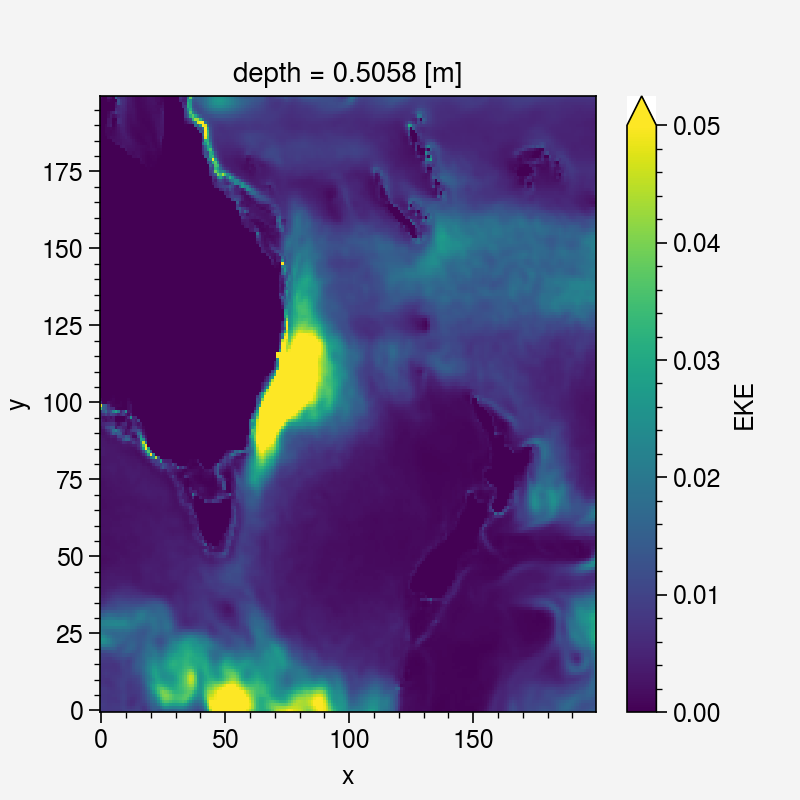

In [33]:
KE_surface.sel(x=slice(250,450),y=slice(250,450)).mean('time').EKE.plot(vmax=.05)

# write file to netcdf

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7fcb04415430>>, <Task finished name='Task-304880' coro=<Scheduler.restart() done, defined at /g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/scheduler.py:5885> exception=CommClosedError("Exception while trying to call remote method 'restart' before comm was established.")>)
Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/distributed/core.py", line 819, in send_recv_from_rpc
    result = awa

In [54]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
client.restart()